## Домашнее задание Numpy Neural Net Exploration (50 баллов)

В этом домашнем задании требуется провести набор экспериментов с нейронной сетью. Для проведения экспериментов нужно доработать представленный фреймворк для обучения нейронной сети на Numpy в проекте **Numpy_NN** c **hinge_loss** функцией ошибки. 


Все необходимые доработки обозначены в проекте `Numpy_NN` тегом **TODO**.

В ноутбуке только сами эксперименты с помощью данных команд - все доработки делать внутри фреймворка.

In [1]:
# Пример импорта модуля
import glob
import pickle
import numpy as np
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "Numpy_NN/src"))

from nn.module import sequential

# пример быстрой перезагрузки модуля без рестарта ноутбука
import importlib
importlib.reload(sequential)

<module 'nn.module.sequential' from '/Users/anymax/Documents/mipt/DL_Sber/DeepLearning_Sber/Numpy Network/Numpy_NN/src/nn/module/sequential.py'>

Вам нужно провести набор экспериментов с CIFAR датасетом и исследовать поведение нейронной сети на этом датасете при разных архитектурах. Пример 1ого эксперимента можно найти в ноутбуке ``Numpy Network/Numpy_NN/test_CIFAR_training.ipynb``

Ваши эксперименты должы быть логичны - старайтесь последовательно строить архитектуру и попытайтесь к концу эксприментов определить комбинацию компонент нейронной сети для лучшего качества. Также же вы можете расширять количеcтво экспериментов, подтверждая это соответсвующими выводами. 

В каждом эксперименте должен быть:
    
    * Процесс обучения нейронной сети с помощью training.train.train
    * Проверка градиента для каждой архитектуры нейронной сети с помощью utils.gradient_check(если это указано в описании эксперимента)
    * Визуализация обучения - воспользоваться методом visualization_utils.plot_learning_curves
    * Рассчет точности общей точности модели и рассчет по классовой точности с помощью sklearn.metrics.classification_report
    * Ваш вывод по результату эксперимента
    
В каждом эксперименте должен быть каждый пункт иначе эксперимент не оценивается. Каждый эксперимент оценивается в **4 балла**. За расширение пространства экспериментов и реализации своих идей можно дополнительно получить до **6 баллов**.

В данном ДЗ оценивается качество работы доработанного вами фреймворка, качество проведения эксперимента и полученный результат. 

### Для начала проанализируем датасет и разделим на три части
Этот ход скопирован из примера

In [3]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2024-02-23 09:13:02--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.3’

     0K .......... .......... .......... .......... ..........  0%  187K 14m51s
    50K .......... .......... .......... .......... ..........  0%  372K 11m9s
   100K .......... .......... .......... .......... ..........  0% 52.1M 7m27s
   150K .......... .......... .......... .......... ..........  0%  374K 7m26s
   200K .......... .......... .......... .......... ..........  0% 32.7M 5m58s
   250K .......... .......... .......... .......... ..........  0% 33.4M 4m59s
   300K .......... .......... .......... .......... ..........  0%  382K 5m18s
   350K .......... .......... .......... .......... ..........  0% 33.0M 4m39s
  

И распакуем его

In [36]:
!tar -xzf cifar-10-python.tar.gz

На выходе будем иметь следующие файлы

In [2]:
files = glob.glob("cifar-10-batches-py/**")
files = [item.split('/')[-1] for item in files]
for file in sorted(files):
    print(f"-{file}")

-batches.meta
-data_batch_1
-data_batch_2
-data_batch_3
-data_batch_4
-data_batch_5
-readme.html
-test_batch


Из этих файлов нас интересуют data_batch_1, data_batch_2, ..., data_batch_5 -- это файлы с тренировочными данными, и файл test_batch -- это файл с тестовыми данными, на которых мы будем измерять свои метрики.

Посмотрим ближе на структуру файлов

In [3]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    train_dataset_1 = pickle.load(f, encoding="bytes")

Датасет содержит следующие ключи:

In [4]:
for key in train_dataset_1.keys():
    print(f"-{key.decode('utf-8')}")

-batch_label
-labels
-data
-filenames


Ключ `batch_label` нас не интересует, так как содержит только лишь информацию о номере бача

In [21]:
train_dataset_1[b'batch_label'].decode('utf-8')

'training batch 1 of 5'

Ключ `filenames` в данном случае нас тоже не интересует, так как он содержит названия файлов, которые мы без привлечения языковых моделей использовать не сможем

In [22]:
print("Первые 10 названий:")
for name in train_dataset_1[b'filenames'][:10]:
    print(f"-{name.decode('utf-8')}")

Первые 10 названий:
-leptodactylus_pentadactylus_s_000004.png
-camion_s_000148.png
-tipper_truck_s_001250.png
-american_elk_s_001521.png
-station_wagon_s_000293.png
-coupe_s_001735.png
-cassowary_s_001300.png
-cow_pony_s_001168.png
-sea_boat_s_001584.png
-tabby_s_001355.png


Остаются два наиболее интересных ключа, это `data` и `labels`.

Как нетрудно догадаться, `labels` содержит классы. Выведем первые 10 элементов:

In [23]:
print(train_dataset_1[b'labels'][:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


Классы представлены числовыми метками. В принципе нам нет необходимости знать соответствие между ними, однако эти данные можно найти в файле `batches.meta`:

In [24]:
with open("cifar-10-batches-py/batches.meta", "rb") as f:
    classes_names = pickle.load(f, encoding="bytes")

for ind, name in enumerate(classes_names[b'label_names']):
    print(f"{ind}: {name.decode('utf-8')}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Ключ `data` содержит уже сами числовые данные

In [25]:
print(f"Количество данных: {len(train_dataset_1[b'data'])}")
print(f"Размер вектора: {train_dataset_1[b'data'][0].shape}")

Количество данных: 10000
Размер вектора: (3072,)


Теперь интересно посмотреть на сбалансированность меток по разбиениям. Для этого загрузим все тестовые разбиения

In [26]:
with open("cifar-10-batches-py/data_batch_2", "rb") as f:
    train_dataset_2 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_3", "rb") as f:
    train_dataset_3 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_4", "rb") as f:
    train_dataset_4 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_5", "rb") as f:
    train_dataset_5 = pickle.load(f, encoding="bytes")

И посчитаем сколько раз каждая метка встречается в каждом датасете

In [27]:
datasets = [train_dataset_1, train_dataset_2, train_dataset_3, 
            train_dataset_4, train_dataset_5]

labels = list(range(10))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|{8:^{9}}|{10:^{11}}|".format(
    "Data 1", 6, "Data 2", 6, "Data 3", 6, "Data 4", 6, "Data 5", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in datasets:
        print("{0:^{1}}|".format(dataset[b'labels'].count(label), 6), end='')
        label_num += dataset[b'labels'].count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|======|======|
|Label|Data 1|Data 2|Data 3|Data 4|Data 5| Sum  |
|=====|======|======|======|======|======|======|
|  0  | 1005 | 984  | 994  | 1003 | 1014 | 5000 |
|  1  | 974  | 1007 | 1042 | 963  | 1014 | 5000 |
|  2  | 1032 | 1010 | 965  | 1041 | 952  | 5000 |
|  3  | 1016 | 995  | 997  | 976  | 1016 | 5000 |
|  4  | 999  | 1010 | 990  | 1004 | 997  | 5000 |
|  5  | 937  | 988  | 1029 | 1021 | 1025 | 5000 |
|  6  | 1030 | 1008 | 978  | 1004 | 980  | 5000 |
|  7  | 1001 | 1026 | 1015 | 981  | 977  | 5000 |
|  8  | 1025 | 987  | 961  | 1024 | 1003 | 5000 |
|  9  | 981  | 985  | 1029 | 983  | 1022 | 5000 |
|=====|======|======|======|======|======|======|


Как видим, данные не сбалансированы по разбиениям, поэтому объединим все в один датасет и разобьем это на два датасета, тренировочный и валидационный, при этом сразу поделим значения каждого вектора на 256, чтобы иметь интенсивность в относительных единицах (хотя максимум на 255)

In [28]:
train_dataset = []

for dataset in datasets:
    for vec, label in zip(dataset[b'data'], dataset[b'labels']):
        train_dataset.append((vec / 256, label))

На валидационную выборку оставим 10000 элементов, по 1000 примеров из каждого класса, выбранных случайно

In [29]:
np.random.seed(42)
np.random.shuffle(train_dataset)

train_data = []
valid_data = []

cnt = {ind: 0 for ind in range(10)}

for vec, label in train_dataset:
    if cnt[label] < 1000:
        cnt[label] += 1
        valid_data.append((vec, label))
    else:
        train_data.append((vec, label))

Подготовим еще тестовый датасет

In [30]:
with open("cifar-10-batches-py/test_batch", "rb") as f:
    test_dataset = pickle.load(f, encoding="bytes")

test_data = []
for vec, label in zip(test_dataset[b'data'], test_dataset[b'labels']):
    test_data.append((vec / 256, label))

Посмотрим на статистики

In [31]:
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|".format(
    "Train", 6, "Valid", 6, "Test", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

labels = list(range(10))
for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in (train_data, valid_data, test_data):
        labels_data = [item[1] for item in dataset]
        print("{0:^{1}}|".format(labels_data.count(label), 6), end='')
        label_num += labels_data.count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|
|Label|Train |Valid | Test | Sum  |
|=====|======|======|======|======|
|  0  | 4000 | 1000 | 1000 | 6000 |
|  1  | 4000 | 1000 | 1000 | 6000 |
|  2  | 4000 | 1000 | 1000 | 6000 |
|  3  | 4000 | 1000 | 1000 | 6000 |
|  4  | 4000 | 1000 | 1000 | 6000 |
|  5  | 4000 | 1000 | 1000 | 6000 |
|  6  | 4000 | 1000 | 1000 | 6000 |
|  7  | 4000 | 1000 | 1000 | 6000 |
|  8  | 4000 | 1000 | 1000 | 6000 |
|  9  | 4000 | 1000 | 1000 | 6000 |
|=====|======|======|======|======|


Перед обучением отнормируем все данные

In [32]:
train_matrix = np.array([item[0] for item in train_data])
D = np.var(train_matrix, axis=0)
E = np.mean(train_matrix, axis=0)

for ind in range(len(train_data)):
    train_data[ind] = (train_data[ind][0] - E, train_data[ind][1])
    train_data[ind] = (train_data[ind][0] / np.sqrt(D), train_data[ind][1])

for ind in range(len(valid_data)):
    valid_data[ind] = (valid_data[ind][0] - E, valid_data[ind][1])
    valid_data[ind] = (valid_data[ind][0] / np.sqrt(D), valid_data[ind][1])

for ind in range(len(test_data)):
    test_data[ind] = (test_data[ind][0] - E, test_data[ind][1])
    test_data[ind] = (test_data[ind][0] / np.sqrt(D), test_data[ind][1])

In [33]:
from dataset.dataloader import Dataloader
from nn.module.sequential import Sequential
from nn.layers.linear import Linear
from nn.layers.batch_norm import BatchNorm
from nn.layers.dropout import Dropout
from nn.activations.relu import ReLU
from nn.activations.sigmoid import Sigmoid
from nn.activations.tanh import Tanh
from optimization.adam_optimizer import Adam
from nn import loss_functions
from training.train import train
from nn.loss_functions.hinge_loss import hinge_loss
from utils import gradient_check
import visualization_utils as viz_utils

from sklearn.metrics import classification_report

### Эксперимент 1 Построение нейронной сети с ReLU функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  

Построим простую трехслойную модель

In [34]:
np.random.seed(42)

In [35]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    ReLU(),
    Linear(128, 20),
    ReLU(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Linear(128, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [40]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ' пройдена'}")

Проверка пройдена                                                                                                                         ] 494/393216 1s>808s


In [42]:
# реальная модель
relu_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 64),
    ReLU(),
    Linear(64, 10)
)
relu_model

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 64, bias=True),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [43]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=relu_model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.7347  | 0.1188  |  2.5951  | 0.1193  | 0.116881 |   8.6    |   8.6    |
| 2/10|  2.5290  | 0.1285  |  2.4297  | 0.1304  | 0.054876 |   8.0    |   16.6   |
| 3/10|  2.3830  | 0.1371  |  2.3074  | 0.1411  | 0.034815 |   6.8    |   23.4   |
| 4/10|  2.2746  | 0.1441  |  2.2175  | 0.1478  | 0.024216 |   7.8    |   31.2   |
| 5/10|  2.1947  | 0.1512  |  2.1510  | 0.1578  | 0.018435 |   8.9    |   40.1   |
| 6/10|  2.1345  | 0.1573  |  2.1001  | 0.1608  | 0.014916 |   6.9    |   47.0   |
| 7/10|  2.0871  | 0.1626  |  2.0586  | 0.1657  | 0.013242 |   8.4    |   55.3   |
| 8/10|  2.0475  | 0.1673  |  2.0233  | 0.1701  | 0.011549 |   7.3    |   62.6   |
| 9/10|  2.0134  | 0.1717  |  1.9925  | 0.1758  | 0.009570 |   8.5    |   71.1   |
|10/10|  1.9832  | 0.1750  |  1.9651  | 0.1785  | 0.008986 |   7.5    |   78.6   |


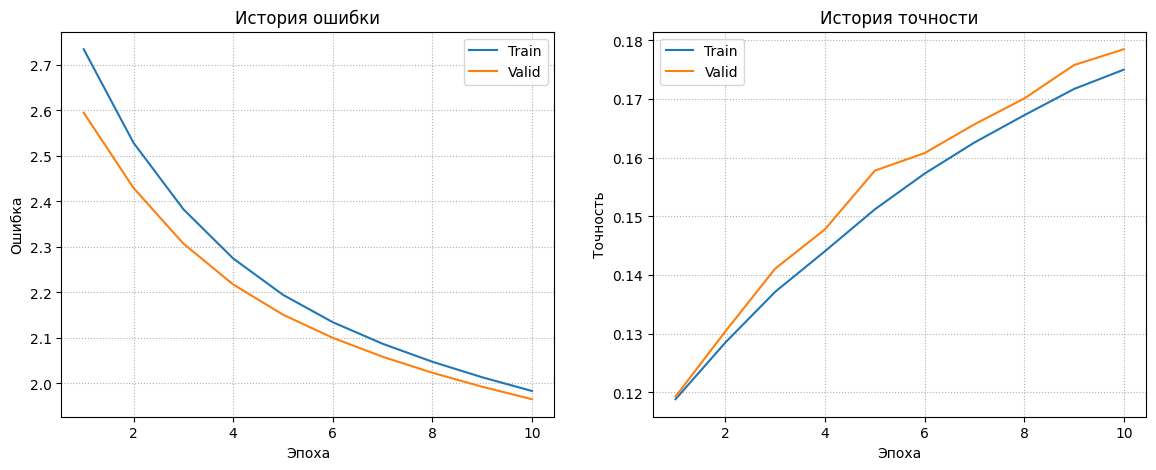

In [44]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [45]:
test_dataloader = Dataloader(test_data, len(test_data), False)
relu_model.eval()
for vecs, labels in test_dataloader:
    out = relu_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.9605
Точность на тесте: 0.1773


In [46]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.25      0.29      0.27      1000
           1       0.15      0.15      0.15      1000
           2       0.13      0.15      0.14      1000
           3       0.14      0.15      0.14      1000
           4       0.15      0.09      0.11      1000
           5       0.16      0.09      0.11      1000
           6       0.16      0.22      0.19      1000
           7       0.10      0.08      0.09      1000
           8       0.28      0.34      0.31      1000
           9       0.20      0.20      0.20      1000

    accuracy                           0.18     10000
   macro avg       0.17      0.18      0.17     10000
weighted avg       0.17      0.18      0.17     10000



##### Вывод  
1) Градиенты считаются верно (прошли проверку)
2) По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно. Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно.
3) Итоговая точность на тесте: 0.1773. Пока выводы хорошо это или плохо делать рано, нужно сравнить с остальными экспериментами
4) По классовой точности можно сказать, что у каждого класса точность не нулевая, но разброс f1-score достаточно большой (0.09 - 0.31), значит под особенности классов, например, 7, 4, 5 модель обучилась плохо и не смогла их хорошо распознать. Общая точность = 0.17, что в целом не плохой результат и лучше baseline (случайный выбор метки)

### Эксперимент 2 Построение нейронной сети с Sigmoid функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.    

Построим простую трехслойную модель

In [47]:
np.random.seed(42)

In [48]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    Sigmoid(),
    Linear(128, 20),
    Sigmoid(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	Sigmoid(),
	Linear(128, 20, bias=True),
	Sigmoid(),
	Linear(20, 10, bias=True)
)

In [49]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ''} пройдена")

Проверка пройдена                                                                           73891/393216 64s>278s


In [50]:
# реальная модель
sigmoid_model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 64),
    Sigmoid(),
    Linear(64, 10)
)
sigmoid_model

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 64, bias=True),
	Sigmoid(),
	Linear(64, 10, bias=True)
)

In [51]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=sigmoid_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.8072  | 0.0990  |  1.7624  | 0.1001  | 0.119939 |   10.6   |   10.6   |
| 2/10|  1.7389  | 0.1001  |  1.7043  | 0.0991  | 0.056202 |   10.5   |   21.1   |
| 3/10|  1.6859  | 0.1019  |  1.6583  | 0.0995  | 0.035030 |   10.5   |   31.6   |
| 4/10|  1.6428  | 0.1057  |  1.6192  | 0.1033  | 0.025901 |   9.0    |   40.6   |
| 5/10|  1.6056  | 0.1118  |  1.5849  | 0.1098  | 0.020634 |   8.6    |   49.2   |
| 6/10|  1.5727  | 0.1182  |  1.5546  | 0.1150  | 0.016886 |   8.5    |   57.7   |
| 7/10|  1.5436  | 0.1222  |  1.5275  | 0.1186  | 0.014277 |   9.1    |   66.8   |
| 8/10|  1.5175  | 0.1263  |  1.5027  | 0.1234  | 0.012619 |   9.1    |   76.0   |
| 9/10|  1.4934  | 0.1290  |  1.4795  | 0.1259  | 0.011138 |   7.9    |   83.8   |
|10/10|  1.4707  | 0.1301  |  1.4575  | 0.1267  | 0.010252 |   9.0    |   92.8   |


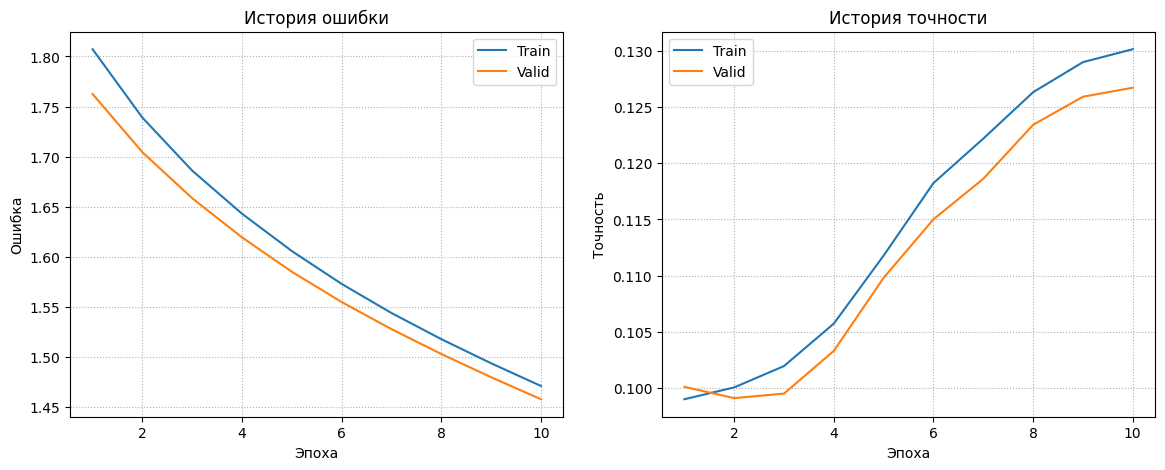

In [52]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [53]:
test_dataloader = Dataloader(test_data, len(test_data), False)
sigmoid_model.eval()
for vecs, labels in test_dataloader:
    out = sigmoid_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.4566
Точность на тесте: 0.1277


In [54]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.20      0.17      0.18      1000
           1       0.12      0.28      0.16      1000
           2       0.11      0.27      0.16      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.10      0.24      0.14      1000
           7       0.00      0.00      0.00      1000
           8       0.16      0.32      0.22      1000
           9       0.08      0.00      0.00      1000

    accuracy                           0.13     10000
   macro avg       0.08      0.13      0.09     10000
weighted avg       0.08      0.13      0.09     10000



/Users/anymax/Documents/mipt/DL_Sber/venv_dl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anymax/Documents/mipt/DL_Sber/venv_dl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anymax/Documents/mipt/DL_Sber/venv_dl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

##### Вывод  
1) Градиенты считаются верно (прошли проверку)
2) По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно. Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно.
3) Итоговая точность на тесте: 0.1277. Из чего можно сделать вывод, что точность модели с Sigmoid функцией активации оказалась хуже чем с RELU. Это может быть связано с тем, что для функции Sigmoid характерно затухание градиентов, а это значит, что некоторые веса модели просто ушли бы в ноль и не принимали участие в обучение, следовательно, худшее качество обучения
4) По классовой точности можно сказать, что разброс f1-score достаточно большой (0.00 - 0.22), значит под особенности классов, например, 3, 4, 5, 7, 9 модель обучилась плохо и вообще не смогла их распознать (нулевой f1-score у этих классов). Но есть классы, особенности которых модель смогла немного уловить. Общая точность = 0.09, что в целом лучше baseline (случайный выбор метки), но хуже предыдущего эксперимента с RELU
Итого, Relu оказывается лучше Sigmoid в данной моделе на данном датасете, значит дальше возьмум модельс Relu как baseline и будем с ней все сравнивать

### Эксперимент 3 Построение нейронной сети с TanH функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

In [55]:
np.random.seed(42)

In [56]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    Tanh(),
    Linear(128, 20),
    Tanh(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	Tanh(),
	Linear(128, 20, bias=True),
	Tanh(),
	Linear(20, 10, bias=True)
)

In [ ]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ''} пройдена")

Проверка пройдена                                                                           3s>                                                 ] 459/393216 0s>688s462/393216 0s>687s1s>680s>                                                 ] 705/393216 1s>670s>                                                 ] 710/393216 1s>671s1s>667s>                                                 ] 829/393216 1s>667s                                                 ] 830/393216 1s>669s1s>667s>                                                 ] 950/393216 1s>667s                                                 ] 1071/393216 1s>665s] 1074/393216 1s>664s>                                                 ] 1191/393216 2s>665s2s>662s2s>662s                                                 ] 1314/393216 2s>663s>                                                 ] 1427/393216 2s>663s                                                 ] 1430/393216 2s>664s                                                 ] 1523/39321

In [58]:
# реальная модель
tanh_model = Sequential(
    Linear(3072, 768),
    Tanh(),
    Linear(768, 64),
    Tanh(),
    Linear(64, 10)
)
tanh_model

Sequential(
	Linear(3072, 768, bias=True),
	Tanh(),
	Linear(768, 64, bias=True),
	Tanh(),
	Linear(64, 10, bias=True)
)

In [59]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=tanh_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.3614  | 0.1068  |  2.2463  | 0.1076  | 0.122930 |   9.5    |   9.5    |
| 2/10|  2.1994  | 0.1178  |  2.1165  | 0.1152  | 0.051527 |   8.5    |   18.0   |
| 3/10|  2.0858  | 0.1274  |  2.0295  | 0.1270  | 0.034668 |   7.8    |   25.8   |
| 4/10|  2.0101  | 0.1348  |  1.9720  | 0.1359  | 0.022167 |   8.0    |   33.8   |
| 5/10|  1.9592  | 0.1416  |  1.9313  | 0.1417  | 0.021706 |   9.1    |   42.9   |
| 6/10|  1.9218  | 0.1477  |  1.8996  | 0.1467  | 0.019404 |   8.3    |   51.2   |
| 7/10|  1.8918  | 0.1534  |  1.8732  | 0.1539  | 0.014669 |   7.8    |   59.0   |
| 8/10|  1.8665  | 0.1583  |  1.8502  | 0.1610  | 0.011820 |   8.2    |   67.2   |
| 9/10|  1.8443  | 0.1632  |  1.8298  | 0.1650  | 0.011994 |   8.4    |   75.6   |
|10/10|  1.8246  | 0.1670  |  1.8117  | 0.1696  | 0.009611 |   8.1    |   83.8   |


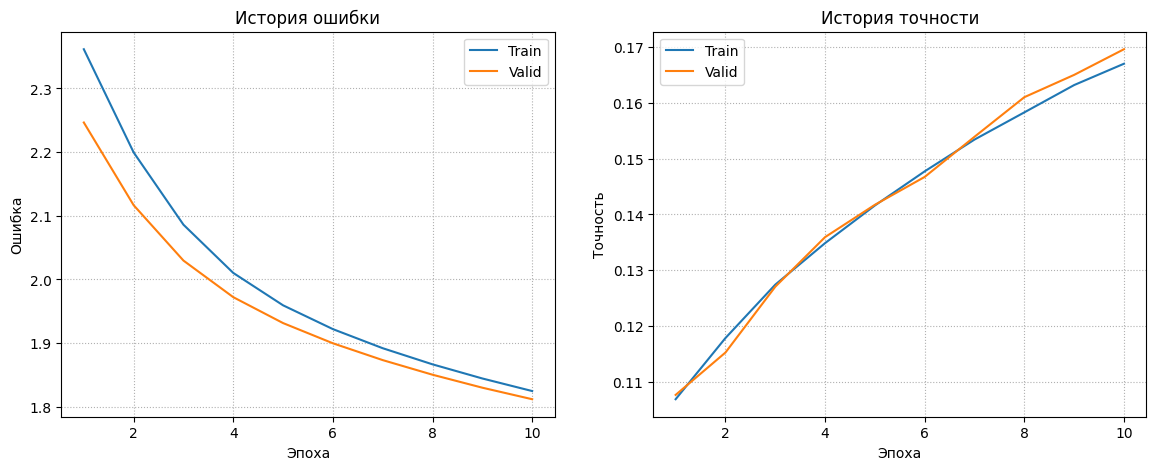

In [60]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [61]:
test_dataloader = Dataloader(test_data, len(test_data), False)
tanh_model.eval()
for vecs, labels in test_dataloader:
    out = tanh_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.8192
Точность на тесте: 0.1640


In [62]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.20      0.18      0.19      1000
           1       0.18      0.14      0.16      1000
           2       0.15      0.17      0.16      1000
           3       0.11      0.07      0.09      1000
           4       0.14      0.15      0.15      1000
           5       0.15      0.11      0.13      1000
           6       0.14      0.17      0.16      1000
           7       0.14      0.16      0.15      1000
           8       0.24      0.30      0.27      1000
           9       0.16      0.17      0.17      1000

    accuracy                           0.16     10000
   macro avg       0.16      0.16      0.16     10000
weighted avg       0.16      0.16      0.16     10000



##### Вывод  
1) Градиенты считаются верно (прошли проверку)
2) По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно. Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно.
3) Итоговая точность на тесте: 0.1640. Из чего можно сделать вывод, что точность модели с Tanh функцией активации оказалась хуже чем с RELU (но лучше чем с Sigmoid). Это может быть связано с тем, что для функции Tanh характерно затухание градиентов, а это значит, что некоторые веса модели просто ушли бы в ноль и не принимали участие в обучение, следовательно, худшее качество обучения (примерно тот же эффект что и с sigmoid)
4) По классовой точности можно сказать, что разброс f1-score достаточно большой (0.09 - 0.27), значит под особенности классов, (например 3) модель обучилась плохо и хуже всех его распознает, нооо у всех классов f1-score не нулевой, а это уже гораздо лучше Sigmoid. Общая точность = 0.16, что  лучше baseline (случайный выбор метки), и совсем немного хуже предыдущего эксперимента с RELU. И при этом намного лучше экспа с Sigmoid. Также хочется отметить, что сбалансированность скора по классам у tanh лучше, чем у RELU (это может быть связано с тем что tanh не обнуляет веса меньше нуля и больше из за этого учитывает особенностей)
  

Итого, Relu оказывается сопоставима с Tanh по результатам в данной моделе на данном датасете. Но в силу большой затраты ресурсов на вычисление модели с активацией Tanh, я предпочитаю остановится на RELU и во всех последующих экспах использовать именно ее.

### Эксперимент 4 Построение нейронной сети с Dropout слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  Подберите оптимальную вероятность в dropout. 

In [ ]:
np.random.seed(42)

In [ ]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    ReLU(),
    Dropout(p=0.4),
    Linear(128, 20),
    ReLU(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Dropout(p=0.4),
	Linear(128, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [ ]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ' пройдена'}")

Проверка пройдена                                                                           1021s] 233/393216 0s>1020s1s>875s>                                                 ] 451/393216 1s>875s>                                                 ] 452/393216 1s>874s                                                 ] 555/393216 1s>852s] 556/393216 1s>852s>                                                 ] 558/393216 1s>852s>                                                 ] 663/393216 1s>833s] 769/393216 1s>818s>                                                 ] 772/393216 1s>820s>                                                 ] 877/393216 1s>811s977/393216 2s>805s 2s>804s>                                                 ] 980/393216 2s>804s1084/393216 2s>797s 2s>798s] 1087/393216 2s>798s 2s>798s] 1191/393216 2s>794s>                                                 ] 1192/393216 2s>794s] 1294/393216 2s>791s1393/393216 2s>789s2s>790s>                                                 ] 139

In [63]:
# реальная модель
dropout_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.4),
    Linear(768, 64),
    ReLU(),
    Linear(64, 10)
)
dropout_model

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.4),
	Linear(768, 64, bias=True),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [64]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=dropout_model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  3.2970  | 0.1128  |  2.5318  | 0.1095  | 0.113919 |   14.4   |   14.4   |
| 2/10|  3.1035  | 0.1243  |  2.3887  | 0.1234  | 0.054010 |   11.1   |   25.5   |
| 3/10|  2.9702  | 0.1354  |  2.2917  | 0.1328  | 0.033932 |   10.7   |   36.2   |
| 4/10|  2.8674  | 0.1429  |  2.2198  | 0.1419  | 0.024373 |   14.2   |   50.4   |
| 5/10|  2.7863  | 0.1479  |  2.1622  | 0.1491  | 0.019088 |   10.5   |   60.9   |
| 6/10|  2.7294  | 0.1522  |  2.1134  | 0.1519  | 0.015689 |   10.5   |   71.4   |
| 7/10|  2.6628  | 0.1567  |  2.0717  | 0.1548  | 0.012844 |   12.0   |   83.4   |
| 8/10|  2.6154  | 0.1598  |  2.0346  | 0.1574  | 0.010932 |   11.0   |   94.4   |
| 9/10|  2.5732  | 0.1623  |  2.0007  | 0.1585  | 0.009935 |   10.9   |  105.3   |
|10/10|  2.5439  | 0.1654  |  1.9704  | 0.1615  | 0.009270 |   10.5   |  115.8   |


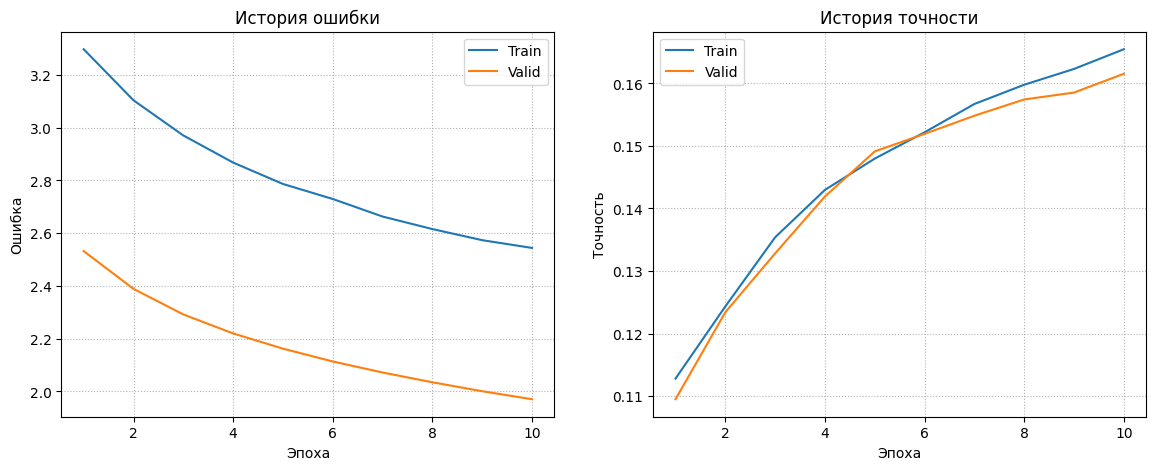

In [65]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [66]:
test_dataloader = Dataloader(test_data, len(test_data), False)
dropout_model.eval()
for vecs, labels in test_dataloader:
    out = dropout_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.9466
Точность на тесте: 0.1655


In [67]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.22      0.44      0.29      1000
           1       0.15      0.18      0.17      1000
           2       0.08      0.07      0.07      1000
           3       0.13      0.16      0.14      1000
           4       0.12      0.15      0.14      1000
           5       0.07      0.00      0.01      1000
           6       0.19      0.27      0.22      1000
           7       0.18      0.10      0.13      1000
           8       0.20      0.24      0.22      1000
           9       0.23      0.03      0.05      1000

    accuracy                           0.17     10000
   macro avg       0.16      0.17      0.14     10000
weighted avg       0.16      0.17      0.14     10000



##### Вывод  
1) Градиенты считаются верно (прошли проверку)
2) По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно. Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно.
3) Итоговая точность на тесте: 0.1655. Из чего можно сделать вывод, что точность модели с Dropout оказалась хуже чем с без. Это может быть связано с тем, что регуляризация на таком маленьком количестве слоев и нейронов и вовсе не нужна, потому что она наоборот может способствовать более плохому запоминанию особенностей классов из за обнуления значительного количества весов
4) По классовой точности можно сказать, что разброс f1-score достаточно большой (0.01 - 0.29), значит под особенности классов, (например 5 и 9) модель обучилась плохо и хуже всех его распознает, нооо у всех классов f1-score не нулевой, а это уже хорошо. Общая точность = 0.14, что  лучше baseline (случайный выбор метки), и хуже чем без Dropout. Опять же это скорее всего из за того что при таком количестве слоев не нужен Dropout
  

Итого, при двух слоях применять Dropout не стоит, а при большем количестве слоев регуляризация уже будет необходима.

### Эксперимент 5 Построение нейронной сети с Batchnorm слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

In [ ]:
np.random.seed(42)

In [ ]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    ReLU(),
    Linear(128, 20),
    BatchNorm(20),
    ReLU(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Linear(128, 20, bias=True),
	BatchNorm(in_dim=20, eps=1e-05),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [ ]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ' пройдена'}")

Проверка пройдена                                                                   15s>139s                                             ] 442/393216 0s>863s] 445/393216 0s>864s1s>851s 1s>851s1s>847s>                                                 ] 735/393216 1s>845s                                                 ] 930/393216 1s>838s>                                                 ] 1216/393216 2s>839s2s>838s 2s>839s2s>840s2s>840s 3s>847s1545/393216 3s>860s1618/393216 3s>870s>                                                 ] 1693/393216 3s>879s>                                                 ] 1701/393216 3s>880s                                                 ] 1715/393216 3s>880s>                                                 ] 1763/393216 3s>887s1773/393216 4s>889s] 1834/393216 4s>896s 4s>895s] 1844/393216 4s>897s 4s>903s 4s>906s                                                 ] 1979/393216 4s>910s4s>915s 4s>915s5s>914s>                                                 ] 2225

In [68]:
# реальная модель
batchnorm_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
batchnorm_model

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [69]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=batchnorm_model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.2454  | 0.1041  |  1.4263  | 0.1031  | 0.153917 |   12.5   |   12.5   |
| 2/10|  1.2431  | 0.1073  |  1.3206  | 0.1044  | 0.101672 |   12.1   |   24.6   |
| 3/10|  1.2409  | 0.1088  |  1.2811  | 0.1072  | 0.071481 |   10.8   |   35.4   |
| 4/10|  1.2387  | 0.1092  |  1.2612  | 0.1093  | 0.084971 |   10.4   |   45.8   |
| 5/10|  1.2366  | 0.1110  |  1.2497  | 0.1099  | 0.056183 |   12.0   |   57.9   |
| 6/10|  1.2345  | 0.1123  |  1.2422  | 0.1107  | 0.039280 |   10.2   |   68.0   |
| 7/10|  1.2324  | 0.1134  |  1.2369  | 0.1118  | 0.036064 |   9.3    |   77.3   |
| 8/10|  1.2304  | 0.1144  |  1.2329  | 0.1128  | 0.029052 |   9.7    |   87.0   |
| 9/10|  1.2284  | 0.1150  |  1.2296  | 0.1138  | 0.032632 |   9.6    |   96.6   |
|10/10|  1.2264  | 0.1155  |  1.2268  | 0.1144  | 0.021109 |   11.0   |  107.6   |


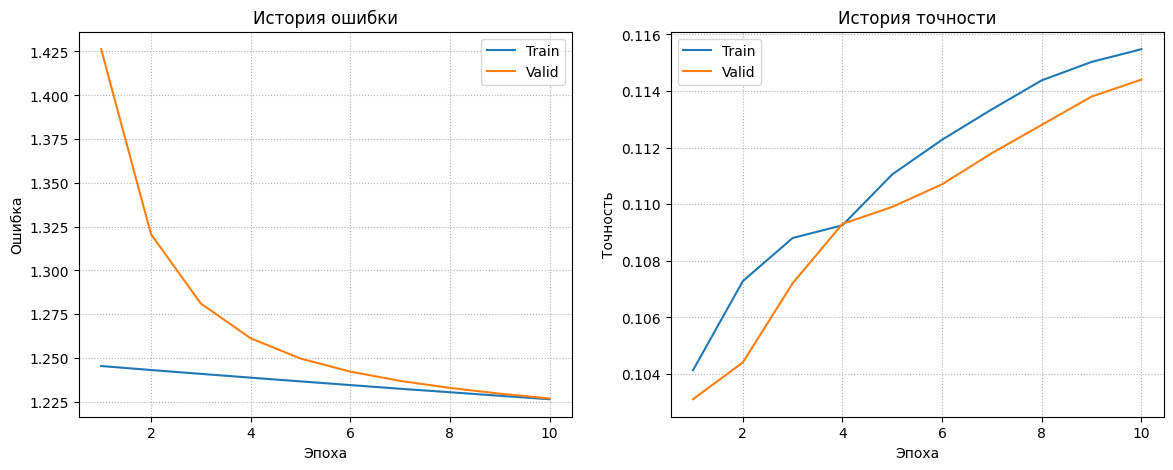

In [70]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [71]:
test_dataloader = Dataloader(test_data, len(test_data), False)
batchnorm_model.eval()
for vecs, labels in test_dataloader:
    out = batchnorm_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.2257
Точность на тесте: 0.1214


In [72]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.20      0.25      0.22      1000
           1       0.10      0.01      0.02      1000
           2       0.10      0.01      0.01      1000
           3       0.10      0.25      0.14      1000
           4       0.14      0.04      0.07      1000
           5       0.09      0.12      0.10      1000
           6       0.13      0.40      0.20      1000
           7       0.09      0.02      0.04      1000
           8       0.15      0.08      0.10      1000
           9       0.06      0.04      0.05      1000

    accuracy                           0.12     10000
   macro avg       0.12      0.12      0.09     10000
weighted avg       0.12      0.12      0.09     10000



##### Вывод  
1) Градиенты считаются верно (прошли проверку)
2) По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно. Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно. Но тут видна особенность в графике ошибке, ошибка на обучении сразу значительно ниже чем на валидации (скорее всего это связано с разным применением слоя BatchNorm при train и inference)
3) Итоговая точность на тесте: 0.1214. Из чего можно сделать вывод, что точность модели с BatchNorm оказалась значительно хуже чем с без. Это может быть связано с тем, что регуляризация на таком маленьком количестве слоев и нейронов и вовсе не нужна, потому что она наоборот может способствовать более плохому запоминанию особенностей классов при данном оптимизаторе, возможно нужно было добавить еще больше эпох
4) По классовой точности можно сказать, что разброс f1-score достаточно большой (0.01 - 0.22), значит под особенности классов, (например 2 и 9) модель обучилась плохо и хуже всех его распознает, нооо у всех классов f1-score не нулевой, а это уже хорошо. Общая точность = 0.09, что  лучше baseline (случайный выбор метки), и хуже чем без BatchNorm. Опять же это скорее всего из за того что при таком количестве нейронов не нужен BatchNorm
  

Итого, при двух слоях применять BatchNorm не стоит, а при большем количестве слоев и нейронов регуляризация уже будет необходима.

### Эксперимент 6 Эксперимент с Adam оптимизатором 

Обучите вашу нейронную сеть с Adam оптимизатором. Подбор гиперпараметров на ваше усмотрение. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

In [ ]:
np.random.seed(42)

In [ ]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    ReLU(),
    Dropout(p=0.1),
    Linear(128, 20),
    BatchNorm(20),
    ReLU(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(128, 20, bias=True),
	BatchNorm(in_dim=20, eps=1e-05),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [ ]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ' пройдена'}")

Проверка пройдена                                                                           /393216 0s>748s>                                                 ] 312/393216 0s>750s>                                                 ] 416/393216 0s>750s>                                                 ] 418/393216 0s>749s624/393216 1s>751s] 626/393216 1s>752s730/393216 1s>750s>                                                 ] 731/393216 1s>750s1s>749s>                                                 ] 840/393216 1s>748s] 940/393216 1s>749s                                                 ] 943/393216 1s>749s>                                                 ] 1042/393216 1s>751s                                                 ] 1044/393216 2s>752s1046/393216 2s>753s 2s>763s] 1131/393216 2s>763s2s>763s>                                                 ] 1134/393216 2s>764s>                                                 ] 1228/393216 2s>766s                                                 ] 12

In [73]:
# реальная модель
adam_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
adam_model

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [74]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=adam_model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1753  | 0.2462  |  1.2938  | 0.2439  | 0.004085 |   14.6   |   14.6   |
| 2/10|  1.0737  | 0.2970  |  1.1059  | 0.2902  | 0.001500 |   12.8   |   27.4   |
| 3/10|  1.0432  | 0.3245  |  1.0588  | 0.3150  | 0.000512 |   11.5   |   38.8   |
| 4/10|  1.0296  | 0.3418  |  1.0371  | 0.3279  | 0.000244 |   11.2   |   50.1   |
| 5/10|  1.0218  | 0.3521  |  1.0262  | 0.3416  | 0.000229 |   11.1   |   61.2   |
| 6/10|  1.0171  | 0.3538  |  1.0197  | 0.3377  | 0.000282 |   10.1   |   71.3   |
| 7/10|  1.0138  | 0.3694  |  1.0140  | 0.3553  | 0.000253 |   10.7   |   82.0   |
| 8/10|  1.0112  | 0.3576  |  1.0125  | 0.3503  | 0.000177 |   10.2   |   92.2   |
| 9/10|  1.0092  | 0.3668  |  1.0094  | 0.3579  | 0.000178 |   11.8   |  104.0   |
|10/10|  1.0075  | 0.3811  |  1.0071  | 0.3685  | 0.000137 |   12.7   |  116.6   |


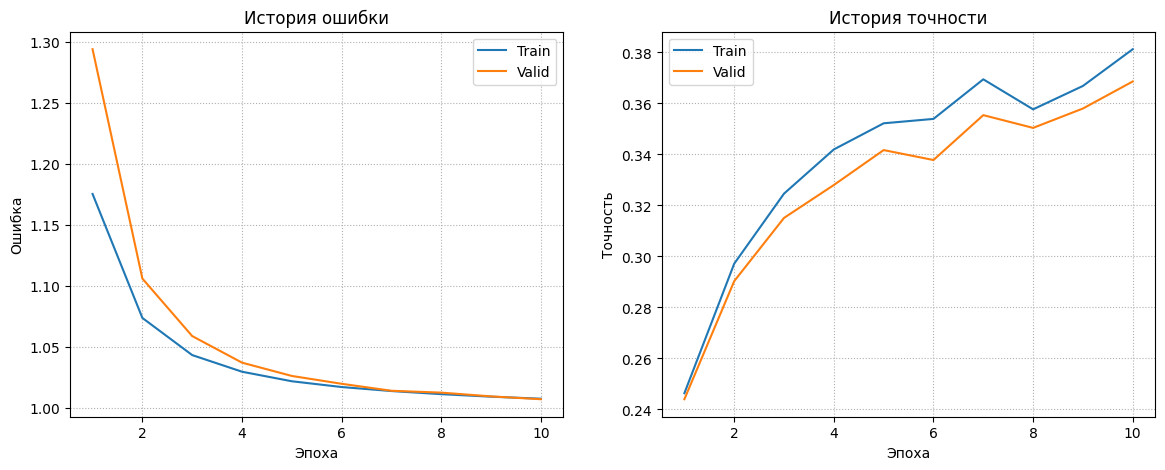

In [75]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [76]:
test_dataloader = Dataloader(test_data, len(test_data), False)
adam_model.eval()
for vecs, labels in test_dataloader:
    out = adam_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0063
Точность на тесте: 0.3747


In [77]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.46      0.50      0.48      1000
           1       0.43      0.47      0.45      1000
           2       0.28      0.33      0.30      1000
           3       0.20      0.07      0.10      1000
           4       0.27      0.18      0.21      1000
           5       0.28      0.45      0.34      1000
           6       0.41      0.31      0.35      1000
           7       0.39      0.44      0.41      1000
           8       0.54      0.51      0.52      1000
           9       0.43      0.50      0.46      1000

    accuracy                           0.37     10000
   macro avg       0.37      0.37      0.36     10000
weighted avg       0.37      0.37      0.36     10000



Плюс посмотрим на модель без dropout и batchnorm слоев

In [78]:
# реальная модель
adam_model_2 = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 64),
    ReLU(),
    Linear(64, 10)
)
adam_model_2

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 64, bias=True),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [79]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=adam_model_2, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
Epoch progress: [>                                                 ] 0/4 0s>0s

| 1/10|  4.1675  | 0.2219  |  3.3344  | 0.2214  | 0.008280 |   12.7   |   12.7   |
| 2/10|  3.1285  | 0.2567  |  2.3857  | 0.2568  | 0.005218 |   11.3   |   23.9   |
| 3/10|  2.0120  | 0.2552  |  1.5644  | 0.2430  | 0.003651 |   11.0   |   34.9   |
| 4/10|  1.4092  | 0.2571  |  1.2546  | 0.2416  | 0.004622 |   11.1   |   46.0   |
| 5/10|  1.2070  | 0.2324  |  1.1504  | 0.2207  | 0.007734 |   11.4   |   57.4   |
| 6/10|  1.0973  | 0.1870  |  1.0544  | 0.1814  | 0.011209 |   11.7   |   69.1   |
| 7/10|  1.0329  | 0.1409  |  1.0223  | 0.1325  | 0.016485 |   10.7   |   79.8   |
| 8/10|  1.0129  | 0.1338  |  1.0100  | 0.1327  | 0.018391 |   11.6   |   91.4   |
| 9/10|  1.0046  | 0.1267  |  1.0054  | 0.1219  | 0.018566 |   11.5   |  102.8   |
|10/10|  1.0016  | 0.1252  |  1.0033  | 0.1195  | 0.018278 |   11.0   |  113.8   |


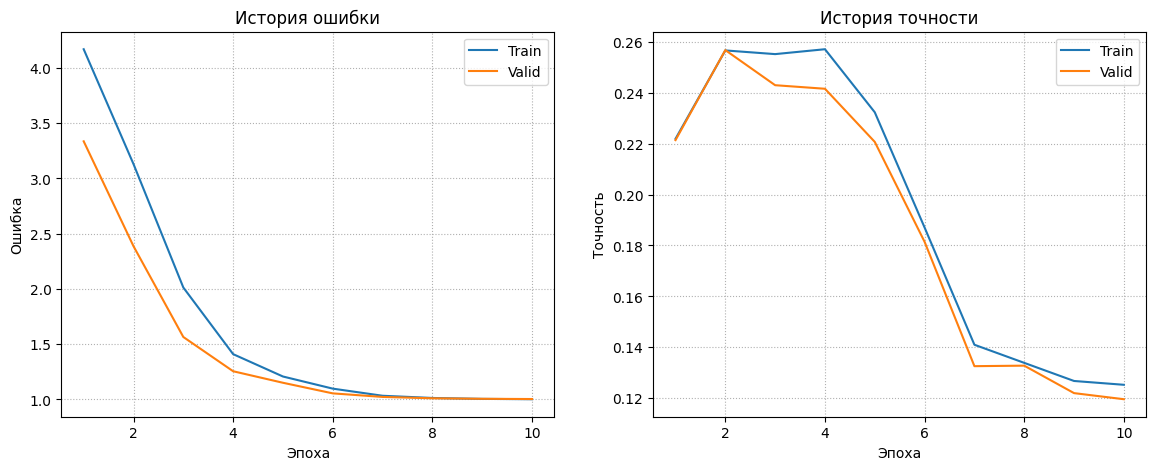

In [80]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [81]:
test_dataloader = Dataloader(test_data, len(test_data), False)
adam_model_2.eval()
for vecs, labels in test_dataloader:
    out = adam_model_2.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0036
Точность на тесте: 0.1219


In [82]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.41      0.04      0.08      1000
           1       0.36      0.00      0.01      1000
           2       0.37      0.02      0.03      1000
           3       0.15      0.00      0.01      1000
           4       0.15      0.01      0.01      1000
           5       0.10      0.97      0.19      1000
           6       0.10      0.00      0.01      1000
           7       0.54      0.04      0.08      1000
           8       0.48      0.12      0.19      1000
           9       0.33      0.01      0.02      1000

    accuracy                           0.12     10000
   macro avg       0.30      0.12      0.06     10000
weighted avg       0.30      0.12      0.06     10000



##### Вывод  
1) Градиенты считаются верно (прошли проверку)
2) 1) С BatchNorm и Dropout: По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно. Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно. Так же можно заметить менее гладкое повышение точности, что своиственно оптимизатору Adam  
    2) Без BatchNorm и Dropout: с историей ошибок все хорошо, а вот с историей точности не очень, точность начала падать, это связано с особенностью оптимизатора Adam скорее всего перескочили минимум и ушли не туда
3) 1)  С BatchNorm и Dropout: Итоговая точность на тесте: 0.3747. Это значительно лучше чем с обычным оптимизатором, в целом ожидаемый результат
    2) Без BatchNorm и Dropout: 0.1219. Намного хуже чем раньше, так что такой вариант больше не рассматриваем, тут как раз видно преимущество всех слоев регуляризации
4) 1)  С BatchNorm и Dropout: По классовой точности можно сказать, что разброс f1-score достаточно большой (0.10 - 0.52), значит под особенности классов, (например 3) модель обучилась хуже и хуже всех его распознает, нооо у всех классов f1-score не нулевой, а это уже хорошо. Общая точность = 0.36, что  лучше baseline (случайный выбор метки), и намного лучше чем было с обычным оптимизатором.
    2) Без BatchNorm и Dropout: точность намного хуже - 0.06, опять же слои регуляризации реально помогают при обучении модели
  

Итого, Adam оптимизатор намного улучшил предсказания модели, но его надо обязательно использовать со слоями регуляризации

### Эксперимент 7 Эксперимент c количеством слоев

Зафиксируйте модель и начинайте добавлять слои. Как меняется качество модели?

In [ ]:
np.random.seed(42)

Рассмотрим влияние количества слоев на примере последней модели с BatchNorm, Dropout и Adam оптимизатором (она тут лучше всех оказалась)

#### База: двухслойная модель

In [83]:
# two layers
model_2 = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
model_2

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [84]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_2, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.2478  | 0.2424  |  1.3540  | 0.2403  | 0.005538 |   12.6   |   12.6   |
| 2/10|  1.1160  | 0.2994  |  1.1504  | 0.2948  | 0.003257 |   14.5   |   27.1   |
| 3/10|  1.0726  | 0.3199  |  1.0983  | 0.3131  | 0.001569 |   11.2   |   38.3   |
| 4/10|  1.0486  | 0.3382  |  1.0665  | 0.3304  | 0.000244 |   10.3   |   48.6   |
| 5/10|  1.0378  | 0.3325  |  1.0540  | 0.3265  | 0.000268 |   11.2   |   59.8   |
| 6/10|  1.0304  | 0.3458  |  1.0415  | 0.3356  | 0.000270 |   11.6   |   71.4   |
| 7/10|  1.0242  | 0.3646  |  1.0285  | 0.3518  | 0.000215 |   13.1   |   84.6   |
| 8/10|  1.0193  | 0.3742  |  1.0213  | 0.3618  | 0.000142 |   12.2   |   96.8   |
| 9/10|  1.0157  | 0.3757  |  1.0167  | 0.3627  | 0.000141 |   11.6   |  108.4   |
|10/10|  1.0127  | 0.3781  |  1.0136  | 0.3666  | 0.000112 |   11.5   |  119.9   |


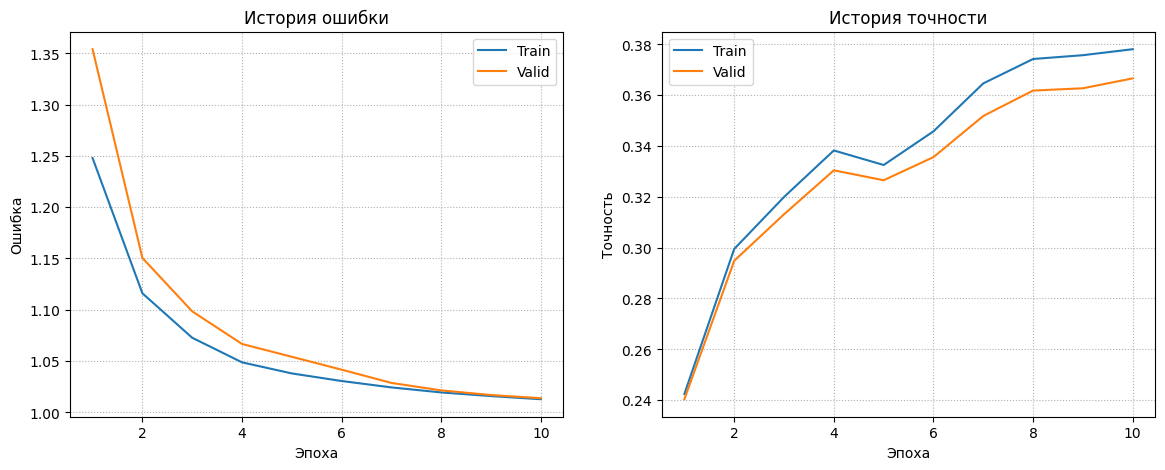

In [85]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [86]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_2.eval()
for vecs, labels in test_dataloader:
    out = model_2.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0118
Точность на тесте: 0.3682


In [ ]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.36      0.54      0.43      1000
           1       0.42      0.39      0.41      1000
           2       0.32      0.14      0.20      1000
           3       0.31      0.07      0.12      1000
           4       0.34      0.27      0.30      1000
           5       0.25      0.49      0.34      1000
           6       0.38      0.38      0.38      1000
           7       0.51      0.32      0.40      1000
           8       0.46      0.53      0.49      1000
           9       0.39      0.53      0.45      1000

    accuracy                           0.37     10000
   macro avg       0.37      0.37      0.35     10000
weighted avg       0.37      0.37      0.35     10000



#### Модель три слоя

In [87]:
# three layers
model_3 = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 384),
    BatchNorm(384),
    ReLU(),
    Dropout(p=0.1),
    Linear(384, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
model_3

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 384, bias=True),
	BatchNorm(in_dim=384, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(384, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [88]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_3, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1831  | 0.2681  |  1.5615  | 0.2587  | 0.003110 |   16.7   |   16.7   |
| 2/10|  1.0723  | 0.3198  |  1.1528  | 0.3041  | 0.001031 |   16.2   |   33.0   |
| 3/10|  1.0447  | 0.3296  |  1.0912  | 0.3205  | 0.000232 |   14.8   |   47.7   |
| 4/10|  1.0320  | 0.3447  |  1.0529  | 0.3370  | 0.000275 |   14.0   |   61.7   |
| 5/10|  1.0228  | 0.3621  |  1.0327  | 0.3491  | 0.000156 |   13.8   |   75.4   |
| 6/10|  1.0168  | 0.3689  |  1.0231  | 0.3542  | 0.000138 |   15.4   |   90.9   |
| 7/10|  1.0116  | 0.3846  |  1.0125  | 0.3724  | 0.000104 |   13.7   |  104.6   |
| 8/10|  1.0076  | 0.3902  |  1.0074  | 0.3744  | 0.000074 |   13.6   |  118.1   |
| 9/10|  1.0039  | 0.4028  |  1.0019  | 0.3821  | 0.000071 |   14.2   |  132.3   |
|10/10|  1.0004  | 0.4141  |  0.9983  | 0.3940  | 0.000074 |   15.5   |  147.9   |


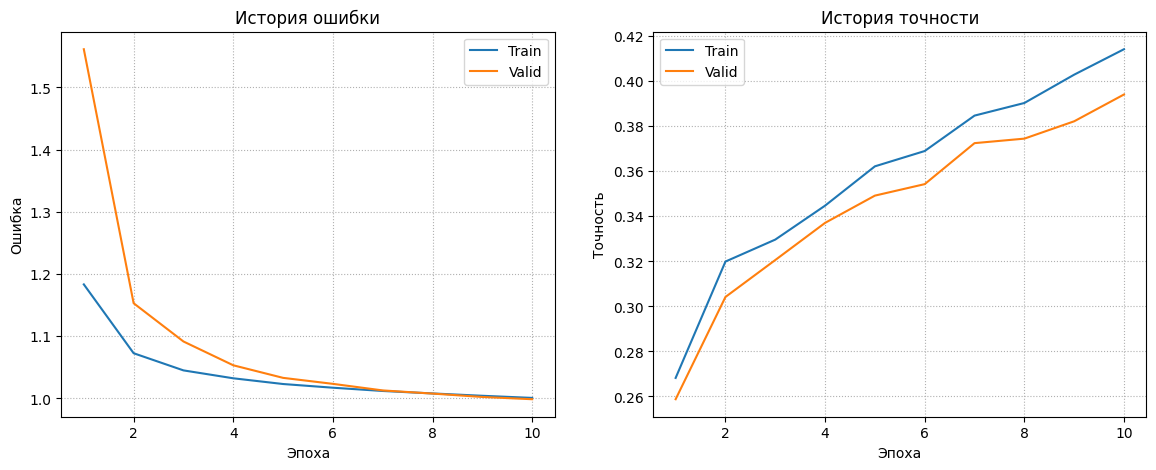

In [89]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [90]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_3.eval()
for vecs, labels in test_dataloader:
    out = model_3.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9948
Точность на тесте: 0.3975


In [91]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.46      0.50      0.48      1000
           1       0.41      0.49      0.44      1000
           2       0.30      0.20      0.24      1000
           3       0.31      0.14      0.19      1000
           4       0.30      0.35      0.33      1000
           5       0.37      0.36      0.37      1000
           6       0.41      0.42      0.42      1000
           7       0.42      0.43      0.43      1000
           8       0.45      0.62      0.52      1000
           9       0.45      0.45      0.45      1000

    accuracy                           0.40     10000
   macro avg       0.39      0.40      0.39     10000
weighted avg       0.39      0.40      0.39     10000



#### Модель четыре слоя

In [92]:
# four layers
model_4 = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 384),
    BatchNorm(384),
    ReLU(),
    Dropout(p=0.1),
    Linear(384, 64),
    BatchNorm(64),
    ReLU(),
    Dropout(p=0.1),
    Linear(64, 32),
    BatchNorm(32),
    ReLU(),
    Linear(32, 10)
)
model_4

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 384, bias=True),
	BatchNorm(in_dim=384, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(384, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(64, 32, bias=True),
	BatchNorm(in_dim=32, eps=1e-05),
	ReLU(),
	Linear(32, 10, bias=True)
)

In [93]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_4, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
Epoch progress: [>                                                 ] 0/4 0s>0s

| 1/10|  1.2598  | 0.2055  |  3.1629  | 0.2039  | 0.002353 |   16.3   |   16.3   |
| 2/10|  1.1268  | 0.2327  |  1.7123  | 0.2248  | 0.000788 |   15.7   |   31.9   |
| 3/10|  1.0938  | 0.2867  |  1.3017  | 0.2752  | 0.000296 |   19.6   |   51.5   |
| 4/10|  1.0739  | 0.3157  |  1.1721  | 0.3031  | 0.000241 |   18.7   |   70.2   |
| 5/10|  1.0624  | 0.3247  |  1.1168  | 0.3101  | 0.000201 |   17.6   |   87.7   |
| 6/10|  1.0529  | 0.3290  |  1.0841  | 0.3142  | 0.000189 |   17.8   |  105.6   |
| 7/10|  1.0445  | 0.3325  |  1.0605  | 0.3198  | 0.000177 |   18.5   |  124.1   |
| 8/10|  1.0389  | 0.3358  |  1.0428  | 0.3251  | 0.000137 |   18.4   |  142.5   |
| 9/10|  1.0328  | 0.3354  |  1.0332  | 0.3221  | 0.000125 |   17.9   |  160.4   |
|10/10|  1.0278  | 0.3301  |  1.0266  | 0.3160  | 0.000137 |   19.5   |  179.9   |


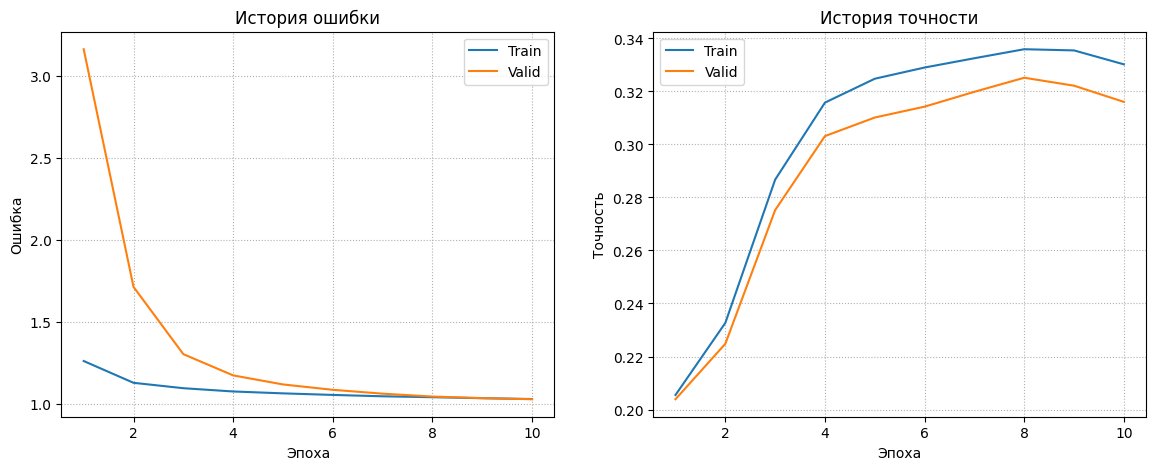

In [94]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [95]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_4.eval()
for vecs, labels in test_dataloader:
    out = model_4.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0201
Точность на тесте: 0.3138


In [96]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.34      0.47      0.39      1000
           1       0.39      0.29      0.33      1000
           2       0.20      0.11      0.14      1000
           3       0.18      0.06      0.09      1000
           4       0.30      0.25      0.27      1000
           5       0.30      0.40      0.34      1000
           6       0.34      0.32      0.33      1000
           7       0.20      0.29      0.24      1000
           8       0.35      0.60      0.44      1000
           9       0.48      0.36      0.41      1000

    accuracy                           0.31     10000
   macro avg       0.31      0.31      0.30     10000
weighted avg       0.31      0.31      0.30     10000



#### Модель пять слоев

In [97]:
# four layers
model_5 = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 384),
    BatchNorm(384),
    ReLU(),
    Dropout(p=0.1),
    Linear(384, 64),
    BatchNorm(64),
    ReLU(),
    Dropout(p=0.1),
    Linear(64, 384),
    BatchNorm(384),
    ReLU(),
    Dropout(p=0.1),
    Linear(384, 20),
    BatchNorm(20),
    ReLU(),
    Linear(20, 10),
)
model_5

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 384, bias=True),
	BatchNorm(in_dim=384, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(384, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(64, 384, bias=True),
	BatchNorm(in_dim=384, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(384, 20, bias=True),
	BatchNorm(in_dim=20, eps=1e-05),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [98]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_5, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
Epoch progress: [>                                                 ] 0/4 0s>0s

| 1/10|  1.3469  | 0.1697  |  6.5797  | 0.1644  | 0.002101 |   21.3   |   21.3   |
| 2/10|  1.1596  | 0.2122  |  2.1748  | 0.2077  | 0.000838 |   21.7   |   43.0   |
| 3/10|  1.1048  | 0.2251  |  1.4615  | 0.2264  | 0.000703 |   22.0   |   65.0   |
| 4/10|  1.0729  | 0.2269  |  1.2406  | 0.2216  | 0.000397 |   21.9   |   86.9   |
| 5/10|  1.0535  | 0.2381  |  1.1283  | 0.2345  | 0.000258 |   22.7   |  109.6   |
| 6/10|  1.0443  | 0.2443  |  1.0780  | 0.2417  | 0.000253 |   20.8   |  130.4   |
| 7/10|  1.0355  | 0.2429  |  1.0535  | 0.2396  | 0.000211 |   20.7   |  151.0   |
| 8/10|  1.0293  | 0.2439  |  1.0405  | 0.2404  | 0.000174 |   21.6   |  172.6   |
| 9/10|  1.0245  | 0.2309  |  1.0305  | 0.2265  | 0.000150 |   22.1   |  194.8   |
|10/10|  1.0187  | 0.2163  |  1.0238  | 0.2114  | 0.000365 |   21.2   |  216.0   |


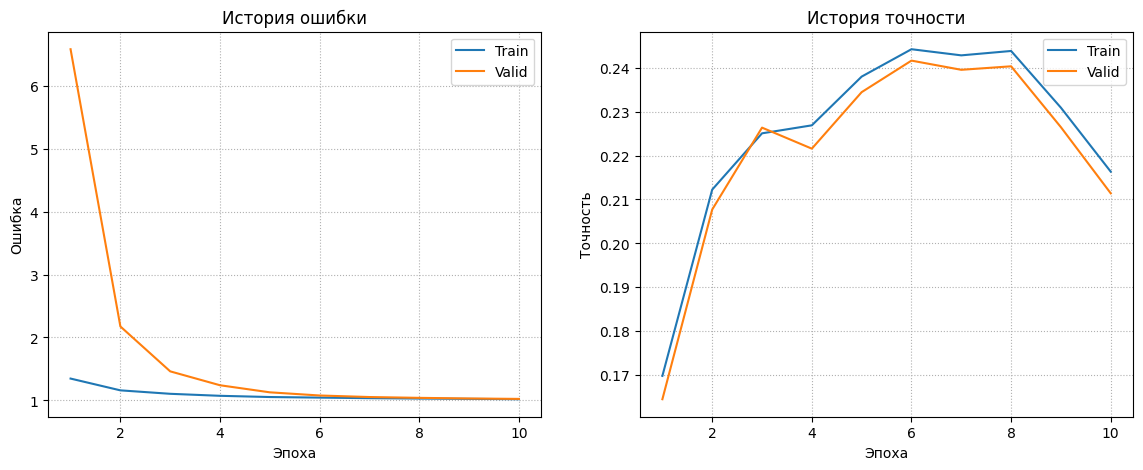

In [99]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [100]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_5.eval()
for vecs, labels in test_dataloader:
    out = model_5.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0206
Точность на тесте: 0.2173


In [101]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.30      0.47      0.37      1000
           1       0.33      0.16      0.22      1000
           2       0.18      0.04      0.07      1000
           3       0.17      0.10      0.12      1000
           4       0.12      0.01      0.02      1000
           5       0.50      0.00      0.01      1000
           6       0.28      0.01      0.03      1000
           7       0.14      0.79      0.24      1000
           8       0.40      0.19      0.26      1000
           9       0.51      0.39      0.44      1000

    accuracy                           0.22     10000
   macro avg       0.29      0.22      0.18     10000
weighted avg       0.29      0.22      0.18     10000



##### Вывод  
1) По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно (при любом количестве слоев). Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно.
2) Что касается количества слоев: Точность на тесте: два слоя: 0.3682, три слоя: 0.3975, четыре слоя: 0.3138, пять слоев: 0.2173. Видно что самый оптимальные вариант количества слоев - 3, после трех точность уже начинает падать и так же глафик точности начинает вести себя неадекватно для 4 и 5 слоев (ухудшается точность с количеством эпох, что может быть связано с затуханием градиентов)
3) f1-score так же лучше всего для трех слоев - 0.39!!! И среди классов точность распределена достаточно равномерна (с разбросом от 0.19 до 0.52). У остального количества слоев этот показатель намного хуже, например, у пяти слоев f1-score = 0.18

Итого, самый адекватный вариант - 3 слоя, запомним это для финального экспа

### Эксперимент 8 Эксперимент c количеством нейронов

Зафиксируйте модель и увеличьте количетсво весов в одном из слоев. Дает ли это прирост качества?

Рассмотрим все ту же модель из двух слоев с BatchNorm и Dropout + Adam  
и поэкспериментируем с нейронами в скрытых слоях

In [ ]:
np.random.seed(42)

In [102]:
# two layers and base
model_base = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
model_base

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [103]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_base, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1714  | 0.2434  |  1.2838  | 0.2382  | 0.002786 |   13.0   |   13.0   |
| 2/10|  1.0722  | 0.2780  |  1.1095  | 0.2702  | 0.001007 |   12.4   |   25.4   |
| 3/10|  1.0451  | 0.3120  |  1.0584  | 0.3008  | 0.000588 |   12.9   |   38.3   |
| 4/10|  1.0324  | 0.3155  |  1.0421  | 0.2997  | 0.000400 |   12.8   |   51.1   |
| 5/10|  1.0262  | 0.3090  |  1.0345  | 0.3000  | 0.000344 |   12.1   |   63.2   |
| 6/10|  1.0208  | 0.3317  |  1.0262  | 0.3228  | 0.000264 |   11.8   |   75.0   |
| 7/10|  1.0171  | 0.3377  |  1.0208  | 0.3220  | 0.000194 |   11.8   |   86.8   |
| 8/10|  1.0142  | 0.3450  |  1.0178  | 0.3338  | 0.000171 |   12.5   |   99.3   |
| 9/10|  1.0121  | 0.3683  |  1.0140  | 0.3571  | 0.000148 |   12.0   |  111.3   |
|10/10|  1.0105  | 0.3823  |  1.0098  | 0.3699  | 0.000109 |   11.7   |  123.0   |


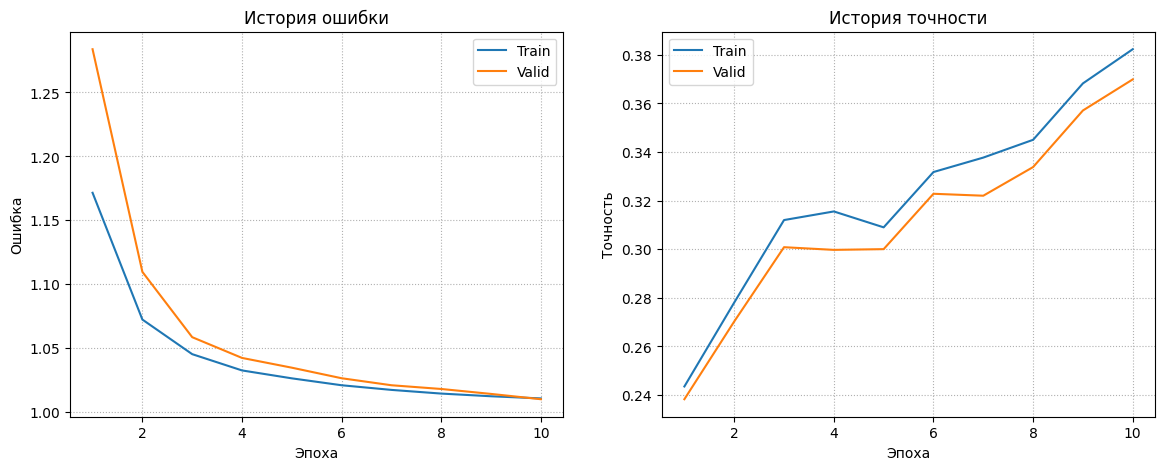

In [104]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [105]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_base.eval()
for vecs, labels in test_dataloader:
    out = model_base.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0091
Точность на тесте: 0.3770


In [106]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.46      0.51      0.48      1000
           1       0.45      0.40      0.42      1000
           2       0.32      0.10      0.15      1000
           3       0.23      0.25      0.24      1000
           4       0.31      0.31      0.31      1000
           5       0.34      0.34      0.34      1000
           6       0.42      0.38      0.40      1000
           7       0.36      0.46      0.41      1000
           8       0.53      0.48      0.51      1000
           9       0.36      0.54      0.44      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.37     10000
weighted avg       0.38      0.38      0.37     10000



In [107]:
# two layers and new_1
model_new_1 = Sequential(
    Linear(3072, 1024),
    ReLU(),
    Dropout(p=0.1),
    Linear(1024, 512),
    BatchNorm(512),
    ReLU(),
    Linear(512, 10)
)
model_new_1

Sequential(
	Linear(3072, 1024, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(1024, 512, bias=True),
	BatchNorm(in_dim=512, eps=1e-05),
	ReLU(),
	Linear(512, 10, bias=True)
)

In [108]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_new_1, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
Epoch progress: [>                                                 ] 0/4 0s>0s

| 1/10|  1.0812  | 0.2725  |  1.1390  | 0.2644  | 0.001330 |   16.4   |   16.4   |
| 2/10|  1.0289  | 0.3202  |  1.0409  | 0.3143  | 0.001549 |   16.0   |   32.4   |
| 3/10|  1.0166  | 0.3445  |  1.0252  | 0.3291  | 0.001220 |   16.5   |   48.9   |
| 4/10|  1.0109  | 0.3748  |  1.0125  | 0.3583  | 0.000917 |   15.6   |   64.5   |
| 5/10|  1.0074  | 0.3696  |  1.0106  | 0.3552  | 0.000822 |   15.4   |   80.0   |
| 6/10|  1.0050  | 0.3852  |  1.0070  | 0.3641  | 0.000820 |   17.2   |   97.2   |
| 7/10|  1.0034  | 0.4173  |  1.0032  | 0.3918  | 0.000452 |   15.5   |  112.7   |
| 8/10|  1.0023  | 0.4254  |  1.0018  | 0.3995  | 0.000478 |   14.9   |  127.6   |
| 9/10|  1.0011  | 0.4300  |  1.0008  | 0.4056  | 0.000729 |   16.0   |  143.5   |
|10/10|  1.0002  | 0.4305  |  1.0002  | 0.4033  | 0.000586 |   16.6   |  160.1   |


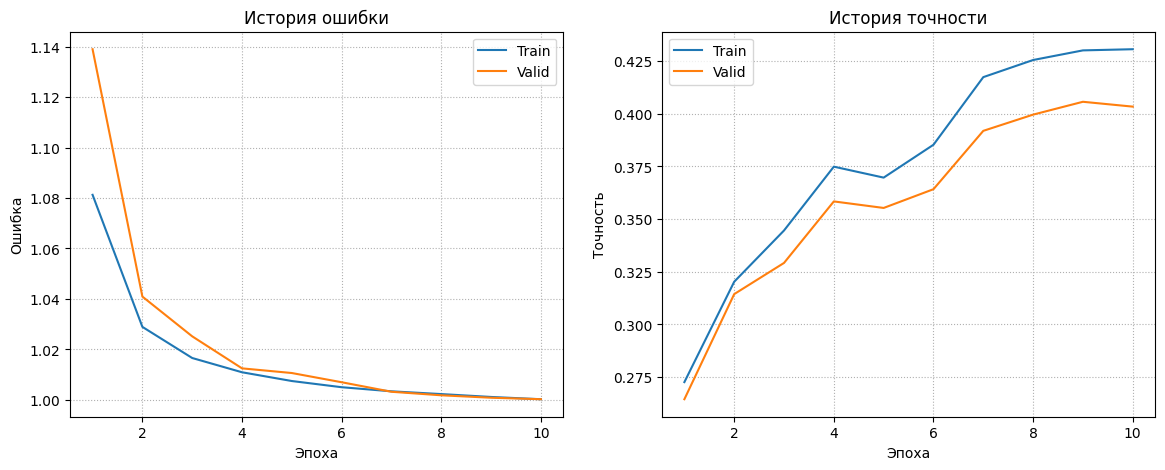

In [109]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [110]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_new_1.eval()
for vecs, labels in test_dataloader:
    out = model_new_1.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9996
Точность на тесте: 0.4182


In [111]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.46      0.50      0.48      1000
           1       0.46      0.50      0.48      1000
           2       0.36      0.23      0.28      1000
           3       0.30      0.19      0.23      1000
           4       0.42      0.21      0.28      1000
           5       0.39      0.39      0.39      1000
           6       0.40      0.57      0.47      1000
           7       0.46      0.47      0.46      1000
           8       0.43      0.65      0.52      1000
           9       0.44      0.46      0.45      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.40     10000
weighted avg       0.41      0.42      0.40     10000



In [112]:
# two layers and new_2
model_new_2 = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 10)
)
model_new_2

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Linear(768, 10, bias=True)
)

In [113]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_new_2, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.0496  | 0.2812  |  1.0816  | 0.2783  | 0.003522 |   12.2   |   12.2   |
| 2/10|  1.0208  | 0.3347  |  1.0267  | 0.3286  | 0.002409 |   10.6   |   22.9   |
| 3/10|  1.0122  | 0.3692  |  1.0147  | 0.3551  | 0.002468 |   11.2   |   34.1   |
| 4/10|  1.0084  | 0.3776  |  1.0094  | 0.3607  | 0.001261 |   10.7   |   44.8   |
| 5/10|  1.0058  | 0.3990  |  1.0056  | 0.3771  | 0.000923 |   12.3   |   57.1   |
| 6/10|  1.0039  | 0.4202  |  1.0029  | 0.3974  | 0.000983 |   11.1   |   68.2   |
| 7/10|  1.0022  | 0.4342  |  1.0007  | 0.4099  | 0.001016 |   12.3   |   80.5   |
| 8/10|  1.0008  | 0.4396  |  0.9997  | 0.4163  | 0.001389 |   10.8   |   91.3   |
| 9/10|  0.9993  | 0.4438  |  0.9985  | 0.4152  | 0.000904 |  843.5   |  934.8   |
|10/10|  0.9978  | 0.4500  |  0.9970  | 0.4205  | 0.000738 |  541.7   |  1476.5  |


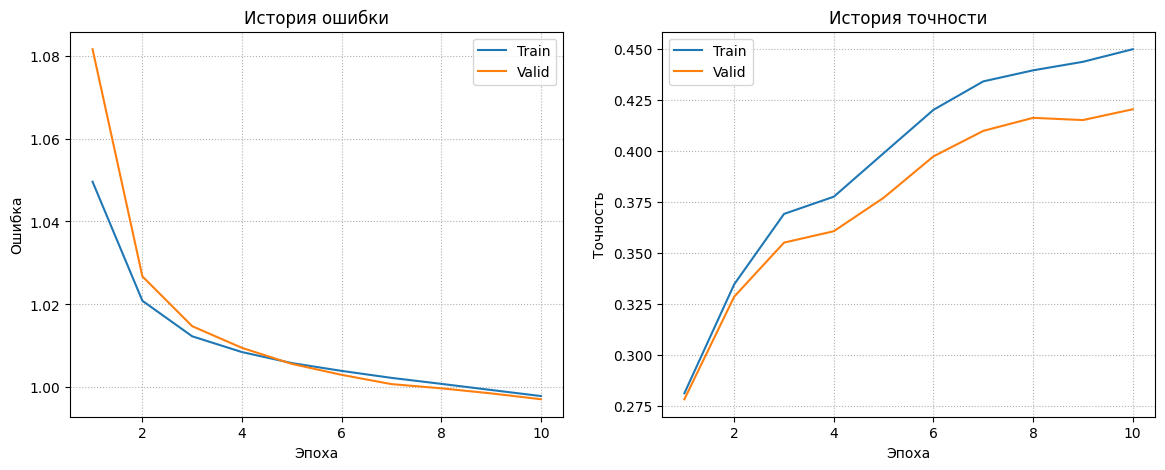

In [114]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [115]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_new_2.eval()
for vecs, labels in test_dataloader:
    out = model_new_2.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9962
Точность на тесте: 0.4295


In [116]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.43      0.56      0.48      1000
           1       0.48      0.52      0.50      1000
           2       0.35      0.27      0.31      1000
           3       0.33      0.19      0.24      1000
           4       0.44      0.25      0.32      1000
           5       0.38      0.37      0.37      1000
           6       0.44      0.49      0.47      1000
           7       0.43      0.53      0.48      1000
           8       0.47      0.65      0.55      1000
           9       0.48      0.46      0.47      1000

    accuracy                           0.43     10000
   macro avg       0.42      0.43      0.42     10000
weighted avg       0.42      0.43      0.42     10000



##### Вывод  
1) По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно (при любом количестве слоев). Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно.
2) Что касается количества слоев: Точность на тесте: первая модель: 0.3770, вторая модель: 0.4182, третья модель: 0.4295. Видно что самый оптимальные вариант - третий, скорее всего это происходит из за того что засчет такого перепада в количестве нейронов скрытых слоев удается выучить больше особенностей классов
3) f1-score так же лучше всего у третьей модели - 0.42!!! И среди классов точность распределена достаточно равномерна (с разбросом от 0.24 до 0.55). У остального количества слоев этот показатель намного хуже, у второй - 0.40, у первой 0.37

Итого, самый адекватный вариант - третья модель, ее и возьмем для дальнеших экспов

### Эксперимент 9 Эксперимент c размером батча

Зафиксируйте модель и обучитесь на разных размерах. Как размер батча влияет на процесс обучения?

Рассмотрим все ту же модель из двух слоев с BatchNorm и Dropout + Adam (лучшую из прошлого экспа)  
и поэкспериментируем с размером батча

In [ ]:
np.random.seed(42)

#### Размер батча 5000

In [117]:
# batch_size = 5000
model_small_batch = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 10)
)
model_small_batch

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Linear(768, 10, bias=True)
)

In [119]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_small_batch, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=5000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.0152  | 0.3987  |  1.0097  | 0.3844  | 0.002807 |   13.3   |   13.3   |
| 2/10|  1.0033  | 0.4293  |  0.9998  | 0.4043  | 0.002215 |   12.7   |   26.0   |
| 3/10|  0.9967  | 0.4566  |  0.9937  | 0.4256  | 0.000475 |   13.7   |   39.8   |
| 4/10|  0.9891  | 0.4626  |  0.9879  | 0.4264  | 0.001047 |   13.2   |   53.0   |
| 5/10|  0.9794  | 0.4725  |  0.9794  | 0.4348  | 0.001186 |   12.3   |   65.3   |
| 6/10|  0.9665  | 0.4846  |  0.9683  | 0.4463  | 0.000673 |   12.8   |   78.1   |
| 7/10|  0.9513  | 0.4878  |  0.9580  | 0.4431  | 0.000722 |   12.0   |   90.1   |
| 8/10|  0.9336  | 0.5091  |  0.9432  | 0.4599  | 0.000406 |   13.1   |  103.2   |
| 9/10|  0.9152  | 0.5264  |  0.9343  | 0.4734  | 0.000390 |   12.7   |  115.9   |
|10/10|  0.9027  | 0.5408  |  0.9287  | 0.4794  | 0.000245 |   12.6   |  128.5   |


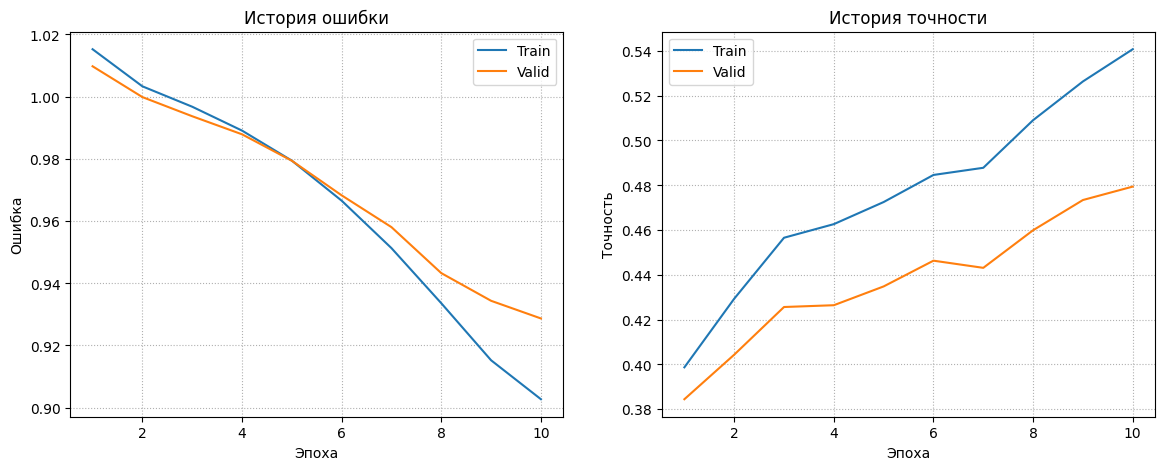

In [120]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [121]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_small_batch.eval()
for vecs, labels in test_dataloader:
    out = model_small_batch.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9261
Точность на тесте: 0.4845


In [122]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57      1000
           1       0.51      0.66      0.58      1000
           2       0.40      0.27      0.32      1000
           3       0.34      0.19      0.25      1000
           4       0.48      0.29      0.36      1000
           5       0.41      0.38      0.39      1000
           6       0.46      0.64      0.54      1000
           7       0.53      0.61      0.57      1000
           8       0.55      0.70      0.61      1000
           9       0.47      0.55      0.51      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



#### Размер батча 20000

In [123]:
# batch_size = 20000
model_medium_batch = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 10)
)
model_medium_batch

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Linear(768, 10, bias=True)
)

In [124]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_medium_batch, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=20000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
Epoch progress: [>                                                 ] 0/2 0s>0s

| 1/10|  1.0764  | 0.2405  |  1.2012  | 0.2356  | 0.005386 |   11.3   |   11.4   |
| 2/10|  1.0413  | 0.2650  |  1.0936  | 0.2591  | 0.002668 |   9.7    |   21.0   |
| 3/10|  1.0307  | 0.2986  |  1.0541  | 0.2893  | 0.002577 |   12.2   |   33.2   |
| 4/10|  1.0221  | 0.3189  |  1.0384  | 0.3092  | 0.002398 |   10.7   |   43.9   |
| 5/10|  1.0169  | 0.3503  |  1.0254  | 0.3368  | 0.002243 |   10.8   |   54.7   |
| 6/10|  1.0138  | 0.3644  |  1.0182  | 0.3536  | 0.002268 |   11.1   |   65.8   |
| 7/10|  1.0112  | 0.3835  |  1.0126  | 0.3657  | 0.002250 |   11.3   |   77.0   |
| 8/10|  1.0096  | 0.3744  |  1.0121  | 0.3570  | 0.001946 |   12.5   |   89.5   |
| 9/10|  1.0082  | 0.3866  |  1.0091  | 0.3740  | 0.001455 |   10.8   |  100.4   |
|10/10|  1.0064  | 0.3888  |  1.0078  | 0.3745  | 0.001433 |   10.2   |  110.6   |


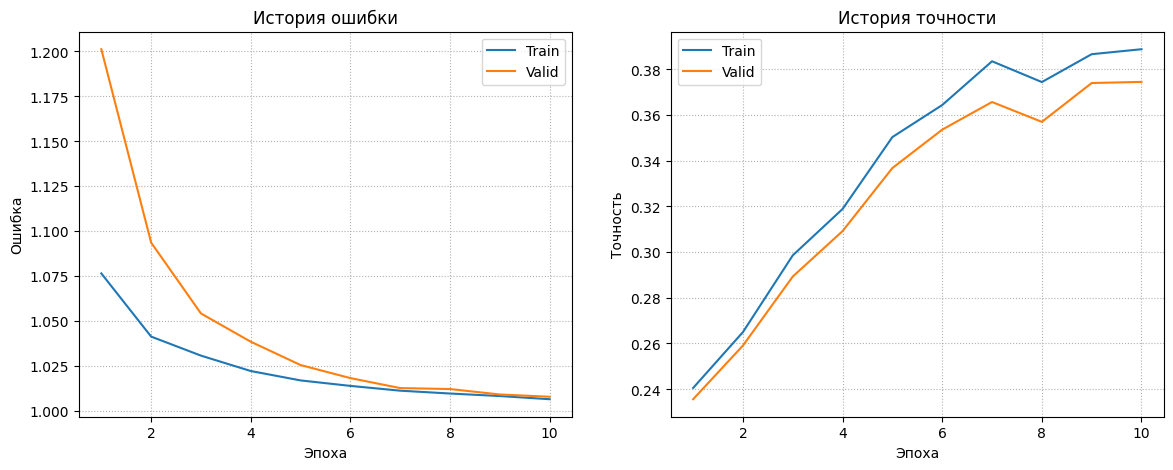

In [125]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [126]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_medium_batch.eval()
for vecs, labels in test_dataloader:
    out = model_medium_batch.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0067
Точность на тесте: 0.3812


In [127]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.38      0.55      0.45      1000
           1       0.43      0.43      0.43      1000
           2       0.33      0.15      0.21      1000
           3       0.34      0.19      0.25      1000
           4       0.30      0.30      0.30      1000
           5       0.42      0.27      0.33      1000
           6       0.36      0.46      0.40      1000
           7       0.42      0.34      0.38      1000
           8       0.43      0.57      0.49      1000
           9       0.38      0.55      0.45      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.37     10000
weighted avg       0.38      0.38      0.37     10000



#### Размер батча 40000

In [128]:
# batch_size = 40000
model_big_batch = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 10)
)
model_big_batch

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Linear(768, 10, bias=True)
)

In [129]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_big_batch, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=40000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
Epoch progress: [>                                                 ] 0/1 0s>0s

| 1/10|  1.0745  | 0.1885  |  1.3220  | 0.1836  | 0.010994 |   11.0   |   11.0   |
| 2/10|  1.0600  | 0.2436  |  1.1585  | 0.2379  | 0.005327 |   9.3    |   20.3   |
| 3/10|  1.0426  | 0.2632  |  1.0998  | 0.2580  | 0.003718 |   9.4    |   29.8   |
| 4/10|  1.0332  | 0.2771  |  1.0797  | 0.2668  | 0.003268 |   9.6    |   39.3   |
| 5/10|  1.0294  | 0.2980  |  1.0599  | 0.2886  | 0.003226 |   9.2    |   48.5   |
| 6/10|  1.0237  | 0.3043  |  1.0480  | 0.2976  | 0.002950 |   10.3   |   58.8   |
| 7/10|  1.0197  | 0.3006  |  1.0417  | 0.2954  | 0.002328 |   11.2   |   70.0   |
| 8/10|  1.0174  | 0.3092  |  1.0347  | 0.3034  | 0.001923 |   10.5   |   80.5   |
| 9/10|  1.0156  | 0.3232  |  1.0277  | 0.3167  | 0.002295 |   10.4   |   90.9   |
|10/10|  1.0139  | 0.3244  |  1.0242  | 0.3208  | 0.002759 |   12.8   |  103.7   |


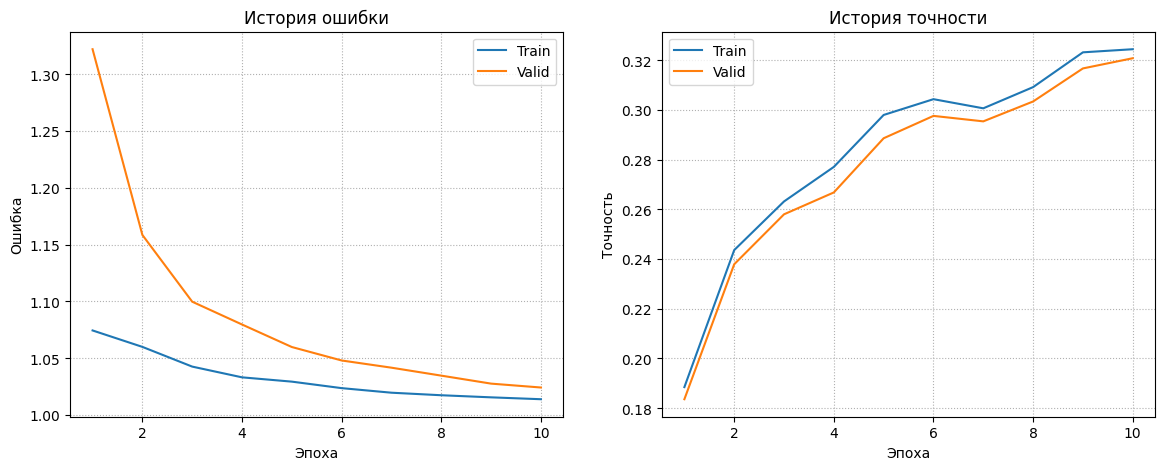

In [130]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [131]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_big_batch.eval()
for vecs, labels in test_dataloader:
    out = model_big_batch.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0238
Точность на тесте: 0.3202


In [132]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.37      0.46      0.41      1000
           1       0.35      0.40      0.37      1000
           2       0.30      0.09      0.13      1000
           3       0.25      0.09      0.13      1000
           4       0.30      0.22      0.25      1000
           5       0.23      0.45      0.30      1000
           6       0.40      0.14      0.21      1000
           7       0.43      0.32      0.37      1000
           8       0.30      0.74      0.43      1000
           9       0.39      0.31      0.35      1000

    accuracy                           0.32     10000
   macro avg       0.33      0.32      0.29     10000
weighted avg       0.33      0.32      0.29     10000



##### Вывод  
1) По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно (при любом количестве слоев). Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно.
2) Что касается количества слоев: Точность для батча = 5000: первая модель: 0.4845, батча = 20000: 0.3812, батча = 40000: 0.3202. Видно что самый оптимальные вариант - маленьких батч, и дальше с увеличением батча точность и ошибка ухудшаются, значит маленький бачт позволяет выучить больше для нашей модели
3) f1-score так же лучше всего у маленького батча - 0.47!!! И среди классов точность распределена достаточно равномерна (с разбросом от 0.25 до 0.61). У остального количества слоев этот показатель намного хуже, у второй - 0.37, у первой 0.29

Итого, самый адекватный вариант - маленьких батч размера 5000, меньше брать не очень хочется потому что это более ресурснозатратно обучать модель на маленькой батче, поэтому остановимся на 5000

### Эксперимент 10 Эксперимент с регуляризацией

Добавьте в процесс обучения L1/L2 регуляризацию. Повлияло ли это на качесвто? Выведите норму весов без регуляризации и с. 

Рассмотрим все ту же модель из двух слоев с BatchNorm и Dropout + Adam (лучшую из прошлого экспа, размер батча 5000)  
и поэкспериментируем с регуляризацией

#### L1 регуляризация

In [134]:
np.random.seed(42)

In [135]:
# l1
model_l1 = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 10)
)
model_l1

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Linear(768, 10, bias=True)
)

In [136]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_l1, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=5000,
    alpha1=0.01)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.0394  | 0.3419  |  1.0303  | 0.3419  | 0.001698 |   12.7   |   12.7   |
| 2/10|  1.0124  | 0.3757  |  1.0112  | 0.3620  | 0.001301 |   13.2   |   25.8   |
| 3/10|  1.0060  | 0.4049  |  1.0040  | 0.3833  | 0.001873 |   12.5   |   38.4   |
| 4/10|  1.0024  | 0.4285  |  1.0007  | 0.3980  | 0.001262 |   13.1   |   51.5   |
| 5/10|  0.9999  | 0.4435  |  0.9981  | 0.4158  | 0.001135 |   12.6   |   64.0   |
| 6/10|  0.9971  | 0.4516  |  0.9959  | 0.4235  | 0.000782 |   12.3   |   76.4   |
| 7/10|  0.9938  | 0.4602  |  0.9927  | 0.4273  | 0.001391 |   12.4   |   88.8   |
| 8/10|  0.9889  | 0.4709  |  0.9880  | 0.4405  | 0.000615 |   12.3   |  101.0   |
| 9/10|  0.9820  | 0.4728  |  0.9832  | 0.4424  | 0.000990 |   12.6   |  113.7   |
|10/10|  0.9720  | 0.4814  |  0.9752  | 0.4477  | 0.000739 |   12.5   |  126.2   |


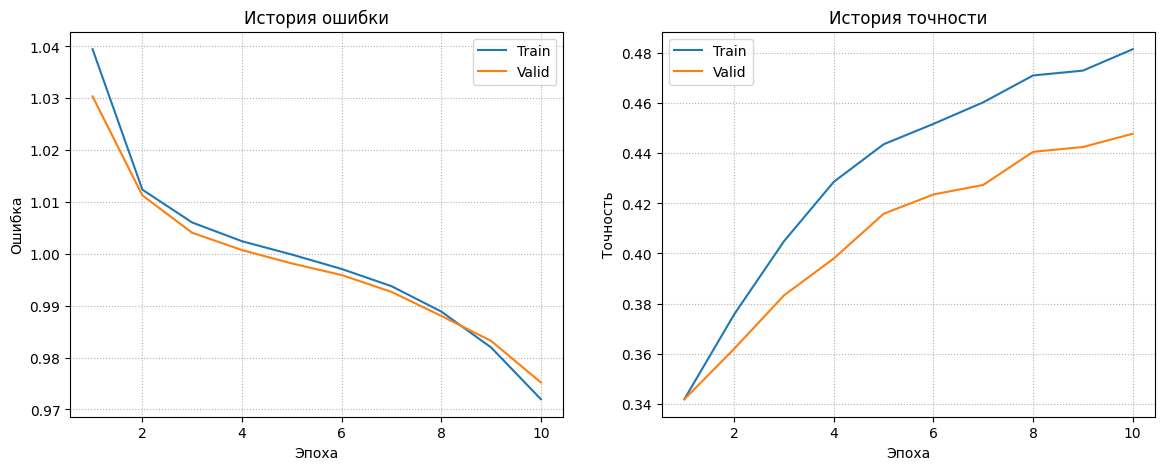

In [137]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [138]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_l1.eval()
for vecs, labels in test_dataloader:
    out = model_l1.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9741
Точность на тесте: 0.4521


In [139]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.57      0.47      0.51      1000
           1       0.50      0.67      0.57      1000
           2       0.38      0.20      0.26      1000
           3       0.33      0.19      0.24      1000
           4       0.41      0.28      0.33      1000
           5       0.44      0.35      0.39      1000
           6       0.45      0.56      0.50      1000
           7       0.40      0.64      0.49      1000
           8       0.48      0.69      0.57      1000
           9       0.49      0.47      0.48      1000

    accuracy                           0.45     10000
   macro avg       0.44      0.45      0.44     10000
weighted avg       0.44      0.45      0.44     10000



#### L2 регуляризация

In [140]:
# l2
model_l2 = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 10)
)
model_l2

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Linear(768, 10, bias=True)
)

In [141]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_l2, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=5000,
    alpha2=0.01)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.0420  | 0.3192  |  1.0332  | 0.3115  | 0.002021 |   13.1   |   13.1   |
| 2/10|  1.0132  | 0.3816  |  1.0112  | 0.3653  | 0.001874 |   12.3   |   25.5   |
| 3/10|  1.0065  | 0.3980  |  1.0046  | 0.3780  | 0.001667 |   12.6   |   38.1   |
| 4/10|  1.0030  | 0.4218  |  1.0014  | 0.3967  | 0.001319 |   13.4   |   51.5   |
| 5/10|  1.0006  | 0.4371  |  0.9990  | 0.4082  | 0.001443 |   12.9   |   64.4   |
| 6/10|  0.9983  | 0.4445  |  0.9969  | 0.4182  | 0.001286 |   11.7   |   76.1   |
| 7/10|  0.9954  | 0.4552  |  0.9940  | 0.4287  | 0.001038 |   12.4   |   88.5   |
| 8/10|  0.9919  | 0.4603  |  0.9903  | 0.4306  | 0.001248 |   13.1   |  101.6   |
| 9/10|  0.9864  | 0.4643  |  0.9855  | 0.4357  | 0.001046 |   12.4   |  114.1   |
|10/10|  0.9785  | 0.4717  |  0.9795  | 0.4385  | 0.001061 |   12.3   |  126.4   |


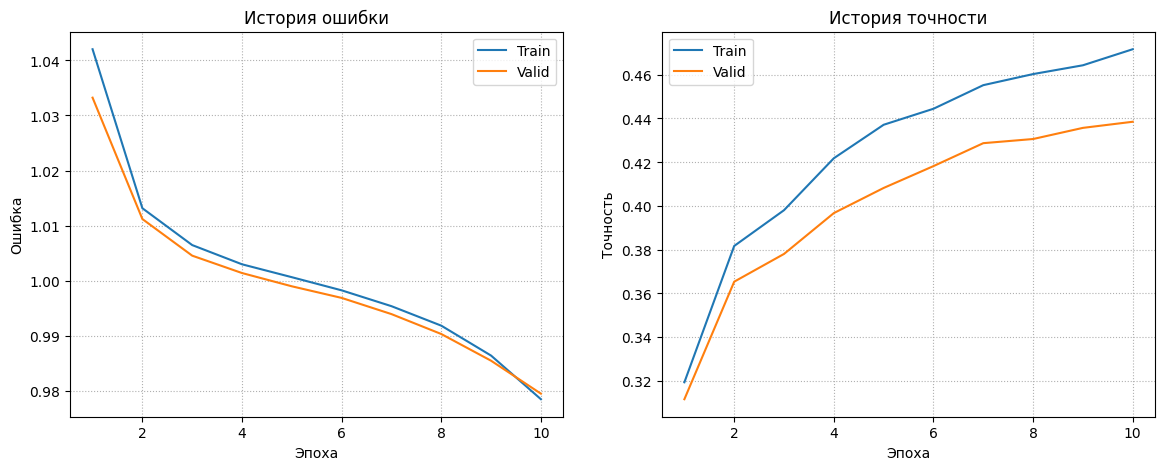

In [142]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [143]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_l2.eval()
for vecs, labels in test_dataloader:
    out = model_l2.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9797
Точность на тесте: 0.4467


In [144]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.57      0.46      0.51      1000
           1       0.47      0.67      0.55      1000
           2       0.32      0.28      0.30      1000
           3       0.39      0.08      0.13      1000
           4       0.39      0.28      0.33      1000
           5       0.36      0.43      0.40      1000
           6       0.46      0.55      0.50      1000
           7       0.45      0.57      0.50      1000
           8       0.50      0.69      0.58      1000
           9       0.50      0.47      0.48      1000

    accuracy                           0.45     10000
   macro avg       0.44      0.45      0.43     10000
weighted avg       0.44      0.45      0.43     10000



#### L2+L1 регуляризация

In [145]:
# l2+l1
model_l2_l1 = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 10)
)
model_l2_l1

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Linear(768, 10, bias=True)
)

In [150]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_l2_l1, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=5000,
    alpha1=0.01,
    alpha2=0.01)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  0.9635  | 0.4762  |  0.9662  | 0.4416  | 0.001073 |   17.5   |   17.5   |
| 2/10|  0.9460  | 0.4917  |  0.9534  | 0.4490  | 0.000854 |   15.0   |   32.5   |
| 3/10|  0.9303  | 0.5225  |  0.9412  | 0.4761  | 0.000478 |   13.1   |   45.6   |
| 4/10|  0.9151  | 0.5303  |  0.9369  | 0.4835  | 0.000437 |   12.8   |   58.4   |
| 5/10|  0.9008  | 0.5423  |  0.9273  | 0.4872  | 0.000465 |   13.2   |   71.6   |
| 6/10|  0.8871  | 0.5558  |  0.9209  | 0.4963  | 0.000571 |   14.4   |   86.1   |
| 7/10|  0.8721  | 0.5656  |  0.9187  | 0.4949  | 0.000456 |   12.5   |   98.5   |
| 8/10|  0.8580  | 0.5786  |  0.9142  | 0.4994  | 0.000305 |   12.2   |  110.7   |
| 9/10|  0.8449  | 0.5903  |  0.9091  | 0.5063  | 0.000293 |   12.0   |  122.7   |
|10/10|  0.8322  | 0.5941  |  0.9100  | 0.5057  | 0.000418 |   13.1   |  135.8   |


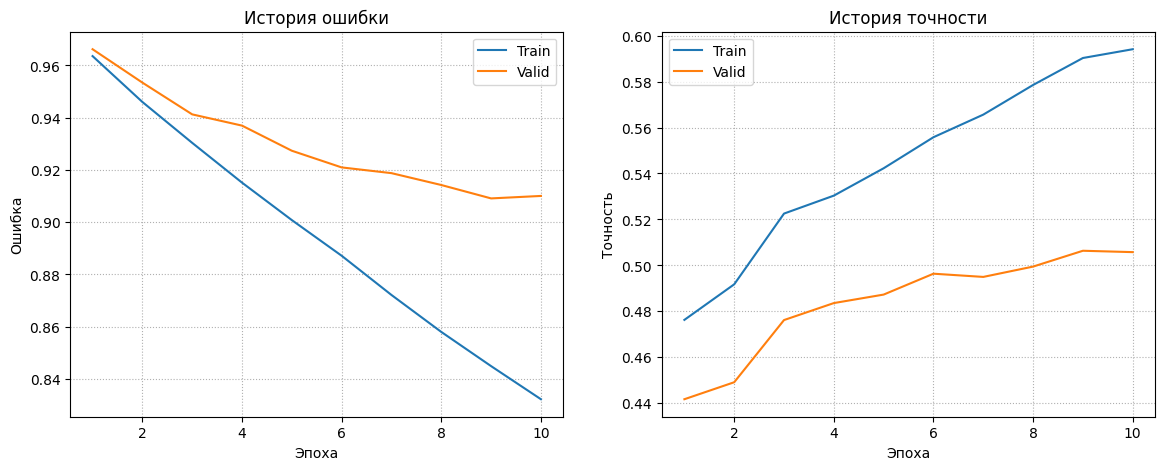

In [151]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [152]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_l2_l1.eval()
for vecs, labels in test_dataloader:
    out = model_l2_l1.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9078
Точность на тесте: 0.5018


In [153]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55      1000
           1       0.59      0.64      0.61      1000
           2       0.42      0.31      0.35      1000
           3       0.35      0.22      0.27      1000
           4       0.45      0.30      0.36      1000
           5       0.45      0.37      0.40      1000
           6       0.48      0.68      0.56      1000
           7       0.51      0.66      0.57      1000
           8       0.56      0.76      0.65      1000
           9       0.50      0.59      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



##### Норма весов

In [154]:
def reg_norm(model):
    num_params = 0
    result = 0
    for param in model.parameters():
        flat_param = param.params.flatten()
        result = result + np.linalg.norm(flat_param)
        num_params = num_params + 1
    result /= num_params
    return result

print("None: ", reg_norm(model_new_2))
print("L_1: ", reg_norm(model_l1))
print("L_2: ", reg_norm(model_l2))
print("L_1+L_2: ", reg_norm(model_l2_l1))

None:  6.493208884972002
L_1:  6.499717409131235
L_2:  6.5664053777755775
L_1+L_2:  6.838490886583544


##### Вывод  
1) По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно (во всех трех случаях регуляризации). Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно.
2) Что касается регуляризации:  
L1 регуляризация: точность = 0.4521, f1-score = 0.44, в целом все классы обучились равномерно. Качество оказалось даже чуть лучше чем без регуляризации. И также лучше обучились отдельные классы, что и свойственно регуляризации  
L2 регуляризация: точность = 0.4467, f1-score = 0.43, в целом все классы обучились равномерно. Качество оказалось даже чуть лучше чем без регуляризации. И также лучше обучились отдельные классы, что и свойственно регуляризации. Также L2 регуляризация оказалась чуть хуже чем L1, но разница незначительна  
L1+L2 регуляризация: точность = 0.4435, f1-score = 0.49, в целом все классы обучились равномерно. Качество оказалось даже чуть лучше чем без регуляризации. И также лучше обучились отдельные классы, что и свойственно регуляризации.  
Итого, лучше всего себя показала L1+L2 регуляризация, ее и будет использовать  

### Эксперимент 11 LR параметр

Рассмотрим все ту же модель из двух слоев с BatchNorm и Dropout + Adam (лучшую из прошлого экспа, l1)  
и поэкспериментируем с lr

In [155]:
np.random.seed(42)

In [156]:
# lr=0.005
model_lr_new_1 = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 10)
)
model_lr_new_1

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Linear(768, 10, bias=True)
)

In [158]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_lr_new_1, 
    epochs=10,
    lr=0.005,
    valid_dataset=valid_data,
    batch_size=5000,
    alpha1=0.01,
    alpha2=0.01)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.0057  | 0.2526  |  0.9975  | 0.2535  | 0.013704 |   12.9   |   12.9   |
| 2/10|  0.9939  | 0.2818  |  0.9911  | 0.2755  | 0.007293 |   15.0   |   28.0   |
| 3/10|  0.9884  | 0.3236  |  0.9863  | 0.3115  | 0.007711 |   13.3   |   41.2   |
| 4/10|  0.9808  | 0.3308  |  0.9803  | 0.3261  | 0.009730 |   13.4   |   54.6   |
| 5/10|  0.9708  | 0.3740  |  0.9717  | 0.3618  | 0.006090 |   13.2   |   67.9   |
| 6/10|  0.9593  | 0.3961  |  0.9708  | 0.3833  | 0.006960 |   13.3   |   81.1   |
| 7/10|  0.9498  | 0.4195  |  0.9600  | 0.4024  | 0.004378 |   14.6   |   95.7   |
| 8/10|  0.9367  | 0.4401  |  0.9453  | 0.4143  | 0.002325 |   13.6   |  109.3   |
| 9/10|  0.9205  | 0.4345  |  0.9337  | 0.4081  | 0.001970 |   13.3   |  122.6   |
|10/10|  0.8987  | 0.4577  |  0.9157  | 0.4293  | 0.001389 |   13.4   |  136.0   |


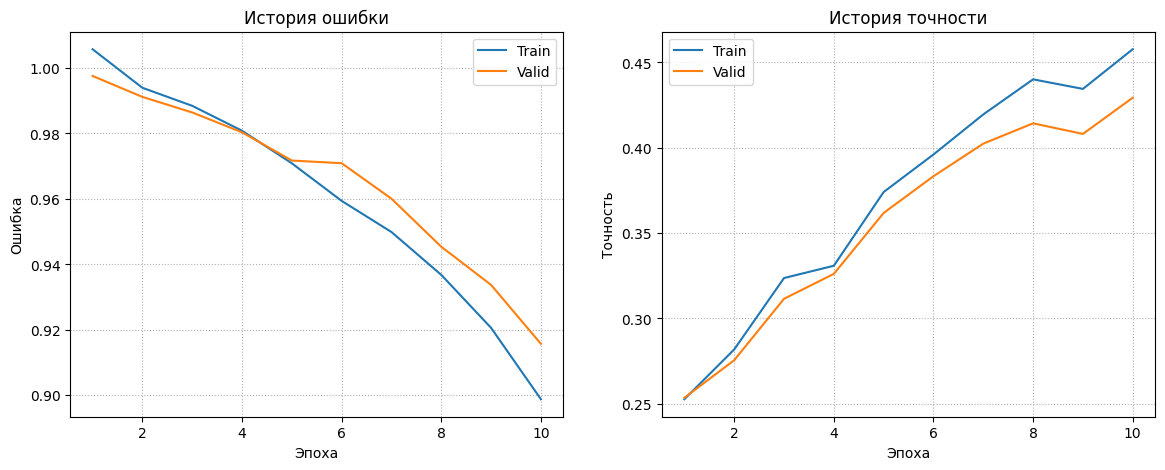

In [159]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [160]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_lr_new_1.eval()
for vecs, labels in test_dataloader:
    out = model_lr_new_1.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9121
Точность на тесте: 0.4376


In [161]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.56      0.50      0.53      1000
           1       0.48      0.65      0.55      1000
           2       0.29      0.17      0.22      1000
           3       0.26      0.28      0.27      1000
           4       0.33      0.34      0.33      1000
           5       0.38      0.29      0.33      1000
           6       0.45      0.55      0.49      1000
           7       0.46      0.49      0.47      1000
           8       0.62      0.60      0.61      1000
           9       0.48      0.50      0.49      1000

    accuracy                           0.44     10000
   macro avg       0.43      0.44      0.43     10000
weighted avg       0.43      0.44      0.43     10000



In [167]:
# lr=0.01
model_lr_new_2 = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 10)
)
model_lr_new_2

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Linear(768, 10, bias=True)
)

In [168]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_lr_new_2, 
    epochs=10,
    lr=0.01,
    valid_dataset=valid_data,
    batch_size=5000,
    alpha1=0.01,
    alpha2=0.01)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.0982  | 0.1904  |  1.1043  | 0.1925  | 0.011240 |   13.6   |   13.6   |
| 2/10|  1.0120  | 0.2247  |  1.0114  | 0.2218  | 0.014447 |   15.5   |   29.1   |
| 3/10|  1.0035  | 0.2019  |  1.0051  | 0.2031  | 0.026444 |   13.6   |   42.7   |
| 4/10|  1.0030  | 0.1766  |  1.0031  | 0.1814  | 0.035385 |   13.0   |   55.7   |
| 5/10|  1.0027  | 0.1933  |  1.0034  | 0.1899  | 0.024583 |   12.8   |   68.5   |
| 6/10|  1.0023  | 0.2167  |  1.0018  | 0.2138  | 0.034456 |   14.9   |   83.5   |
| 7/10|  1.0008  | 0.2125  |  1.0002  | 0.2112  | 0.035295 |   12.6   |   96.1   |
| 8/10|  0.9992  | 0.2088  |  0.9967  | 0.2087  | 0.040322 |   13.0   |  109.1   |
| 9/10|  0.9956  | 0.2215  |  0.9944  | 0.2213  | 0.024797 |   13.2   |  122.3   |
|10/10|  0.9931  | 0.2015  |  0.9908  | 0.2004  | 0.022360 |   13.5   |  135.8   |


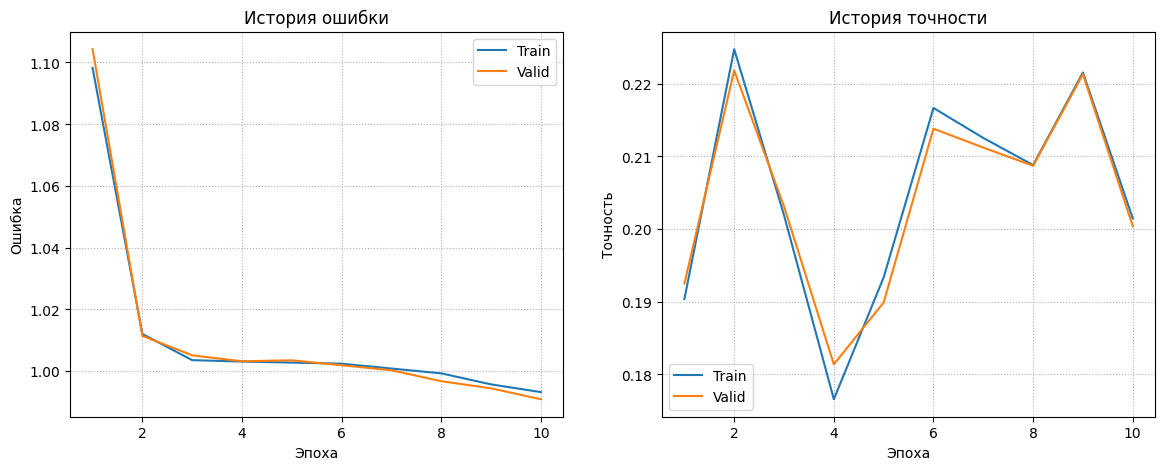

In [169]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [170]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_lr_new_2.eval()
for vecs, labels in test_dataloader:
    out = model_lr_new_2.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9902
Точность на тесте: 0.2015


In [171]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.55      0.40      0.46      1000
           1       0.46      0.07      0.12      1000
           2       0.30      0.00      0.01      1000
           3       0.12      0.88      0.20      1000
           4       0.13      0.00      0.00      1000
           5       0.57      0.11      0.18      1000
           6       0.46      0.05      0.09      1000
           7       0.12      0.01      0.02      1000
           8       0.46      0.47      0.47      1000
           9       0.40      0.03      0.05      1000

    accuracy                           0.20     10000
   macro avg       0.36      0.20      0.16     10000
weighted avg       0.36      0.20      0.16     10000



##### Вывод  
1) По графикам видно, что в ходе обучения ошибка на тренировочной и валидационной выборке падала равномерно (во всех трех случаях lr). Так же точность росла равномерно на двух этих выборках. Заметно, что переобучения не произошло, потому что графики на train и validation падали и росли одинаково и не было расхождений в противоположные стороны. Итого, модель обучилась корректно и адекватно.
2) Что касается lr: все таки лучше всего был изначальный равный lr=0.001, слишком большой lr по графику знаметно что перескакивал минимум функции и быстро упал в ошибке в начале, но потом опускался очень медленно

### Эксперимент 11 Финальная архитектура

Как выглядит ваша финальная модель?

Соберем со всех экспов все самое лучшее и посмотрим на готовый результат

1) Активация: RELU
2) Добавление BatchNorm & Dropout
3) Adam оптимизатор
4) 3-ех слойная модель
5) Количество нейронов (лучшая из экспа)
6) Размер батча 1000 (лучше чем 5000)
7) l1+l2 регуляризация
8) lr = 0.001  
Что изменилось? По результатам экспа с батчами было заметно что чем меньше тем лучше, поэтому попробуем уменьшить до 1000. Так же во всех графиках было видно что можно было увеличить количество эпох, потому что модель не достигла того момента когда мог бы быть минимум, поэтому можно попробовать сделать 20 эпох (в экспах было бы слишком долго постоянно на 20 эпох обучаться, там главно что бы была видно тенденция)

In [166]:
np.random.seed(42)

In [172]:
# result
model_best = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
model_best

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [173]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_best, 
    epochs=20,
    lr=0.0005,
    valid_dataset=valid_data,
    batch_size=1000,
    alpha1=0.01,
    alpha2=0.01)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
Epoch progress: [>                                                 ] 0/40 0s>0s

| 1/20|  1.0471  | 0.3796  |  1.0064  | 0.3731  | 0.000156 |   29.1   |   29.1   |
| 2/20|  1.0019  | 0.4127  |  0.9872  | 0.3975  | 0.000127 |   28.0   |   57.1   |
| 3/20|  0.9828  | 0.4427  |  0.9715  | 0.4157  | 0.000117 |   32.0   |   89.1   |
| 4/20|  0.9589  | 0.4584  |  0.9517  | 0.4283  | 0.000123 |   27.2   |  116.4   |
| 5/20|  0.9336  | 0.4847  |  0.9348  | 0.4511  | 0.000090 |   31.0   |  147.4   |
| 6/20|  0.9099  | 0.4966  |  0.9272  | 0.4547  | 0.000111 |   28.4   |  175.9   |
| 7/20|  0.8880  | 0.5115  |  0.9123  | 0.4617  | 0.000105 |   29.8   |  205.6   |
| 8/20|  0.8682  | 0.5268  |  0.9042  | 0.4697  | 0.000122 |   28.1   |  233.8   |
| 9/20|  0.8510  | 0.5411  |  0.8965  | 0.4799  | 0.000156 |   29.0   |  262.8   |
|10/20|  0.8342  | 0.5542  |  0.8885  | 0.4831  | 0.000110 |   29.1   |  291.9   |
|11/20|  0.8193  | 0.5609  |  0.8923  | 0.4866  | 0.000082 |   29.1   |  321.0   |
|12/20|  0.8054  | 0.5690  |  0.8898  | 0.4888  | 0.000097 |   29.7   |  350.7   |
|13/

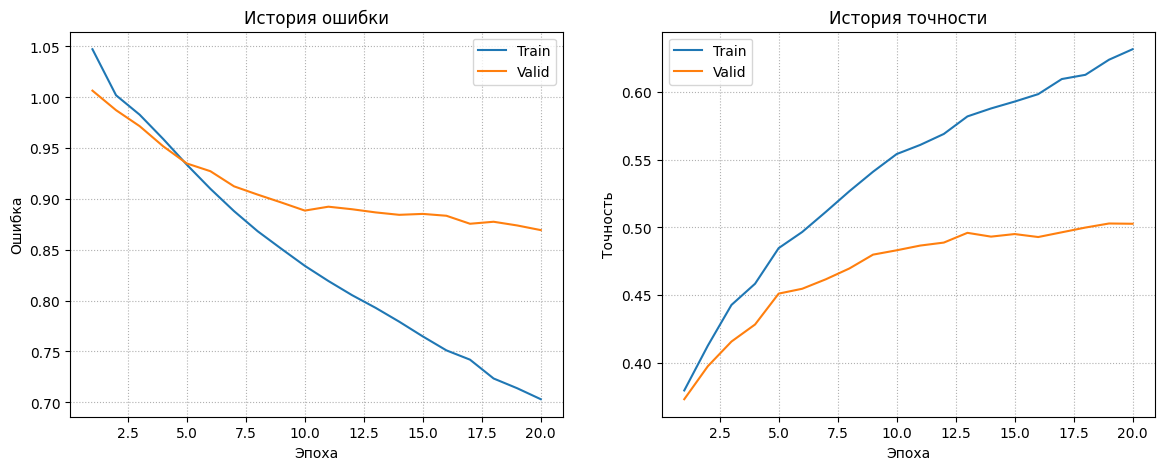

In [174]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [175]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_best.eval()
for vecs, labels in test_dataloader:
    out = model_best.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.8770
Точность на тесте: 0.5044


In [176]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57      1000
           1       0.62      0.70      0.66      1000
           2       0.34      0.34      0.34      1000
           3       0.33      0.24      0.28      1000
           4       0.41      0.40      0.40      1000
           5       0.45      0.32      0.37      1000
           6       0.44      0.65      0.53      1000
           7       0.63      0.56      0.59      1000
           8       0.62      0.69      0.66      1000
           9       0.59      0.56      0.57      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



#### Вывод
Собрав все лучшие экспы в один, мы получили самое лучшее качество!)  
Также по графику истории ошбики видно что лосс на валидации уже не падает, а на обучении падает, это значит что достигли ту стадию перед переобучением и такого количества эпох достаточно